By [Kevin Michalewicz](https://kevinmichalewicz.com) on May 2023

This notebook discusses feature interpretation in the context of ANTIPASTI.

In [1]:
# General imports
import cv2
import glob
import itertools
import os
import pandas as pd
import matplotlib
import numpy as np
import subprocess
import torch

from copy import deepcopy
from matplotlib.colors import CenteredNorm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# for reading and displaying images
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from scipy.stats import chi2
%matplotlib inline

# PyTorch-related libraries
from adabelief_pytorch import AdaBelief

# ANTIPASTI
from antipasti.model.model import ANTIPASTI
from antipasti.preprocessing.preprocessing import Preprocessing
from antipasti.utils.biology_utils import get_cdr_lengths, get_types_of_residues
from antipasti.utils.explaining_utils import compute_change_in_kd, compute_umap, get_epsilon, get_test_contribution, get_maps_of_interest, map_residues_to_regions, plot_map_with_regions
from antipasti.utils.torch_utils import load_checkpoint

# Loading results

In [2]:
# Parameters
modes = 30
n_filters = 2
filter_size = 4
pooling_size = 1
n_max_epochs = 552

mode = 'fully-extended' # Choose between 'fully-extended' and 'fully-cropped'
pathological = ['5omm', '1mj7', '1qfw', '1qyg', '4ffz', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t']
stage = 'predicting'
regions = 'paired_hl'

test_data_path = '../notebooks/test_data/'
test_dccm_map_path = 'dccm_map/'
test_residues_path = 'list_of_residues/'
test_structure_path = 'structure/'
test_pdb = '1t66'

# Pre-processing
preprocessed_data = Preprocessing(modes=modes, pathological=pathological, regions=regions, mode=mode, stage=stage, test_data_path=test_data_path, test_dccm_map_path=test_dccm_map_path, test_residues_path=test_residues_path, test_structure_path=test_structure_path, test_pdb_id=test_pdb)
input_shape = preprocessed_data.test_x.shape[-1]

# Loading the actual checkpoint and learnt filters
path = '../checkpoints/model_' + regions + '_epochs_' + str(n_max_epochs) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
model = load_checkpoint(path, input_shape)[0]
learnt_filter = np.load('../checkpoints/learnt_filter_'+regions+'_epochs_'+str(n_max_epochs)+'_modes_'+str(modes)+'_pool_'+str(pooling_size)+'_filters_'+str(n_filters)+'_size_'+str(filter_size)+'.npy')
model.eval()

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


ANTIPASTI(
  (conv1): Conv2d(1, 2, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropit): Dropout(p=0.05, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=154568, out_features=1, bias=False)
)

# Obtaining maps of interest

In [3]:
mean_learnt, mean_image, mean_diff_image = get_maps_of_interest(preprocessed_data, learnt_filter)

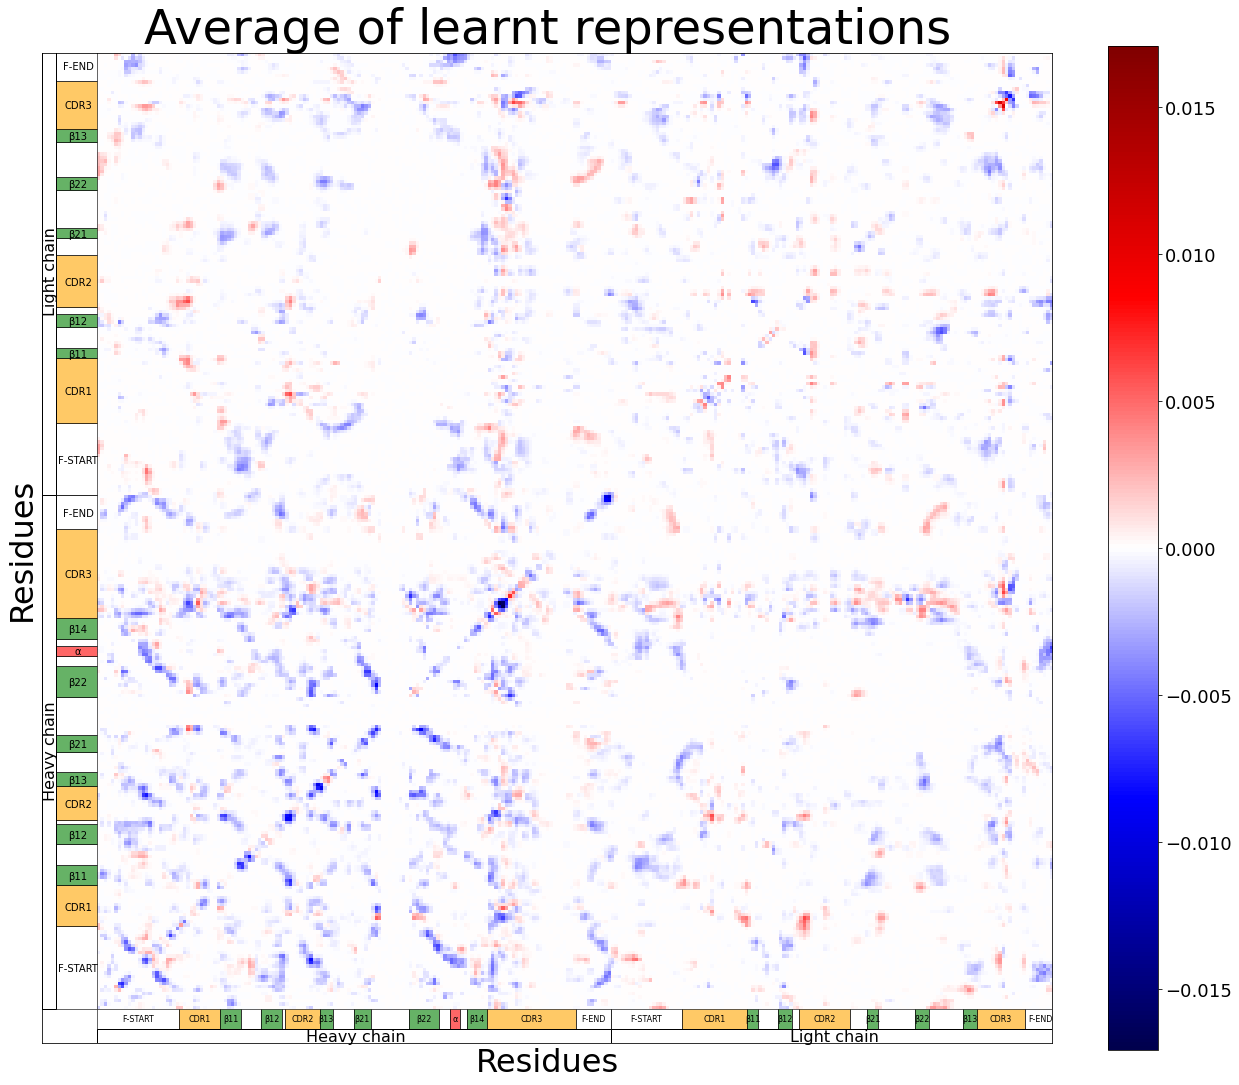

In [4]:
plot_map_with_regions(preprocessed_data, mean_learnt, 'Average of learnt representations')

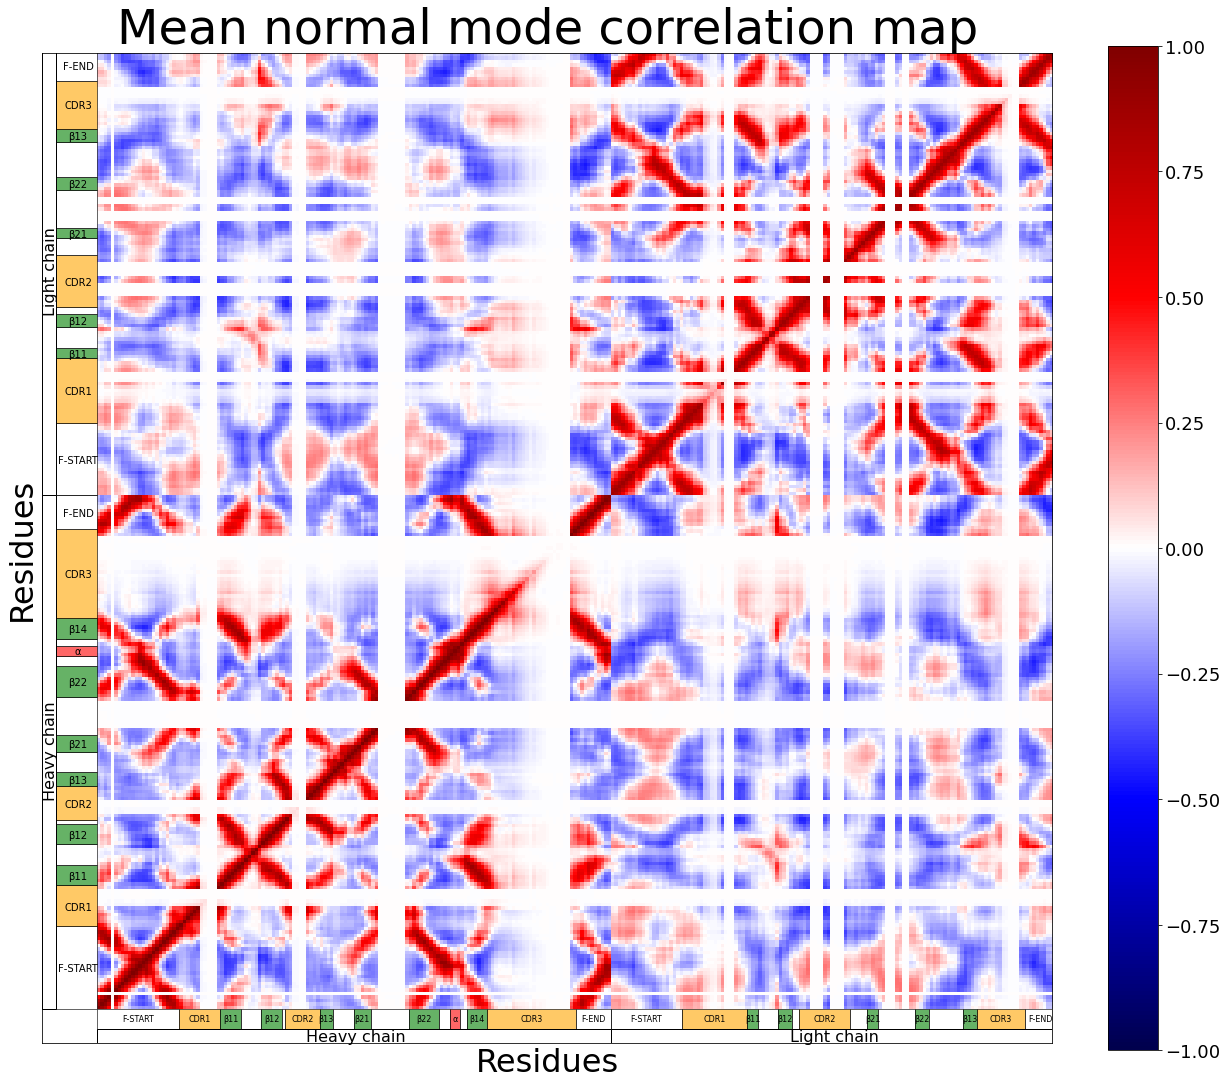

In [5]:
plot_map_with_regions(preprocessed_data, mean_image, 'Mean normal mode correlation map')

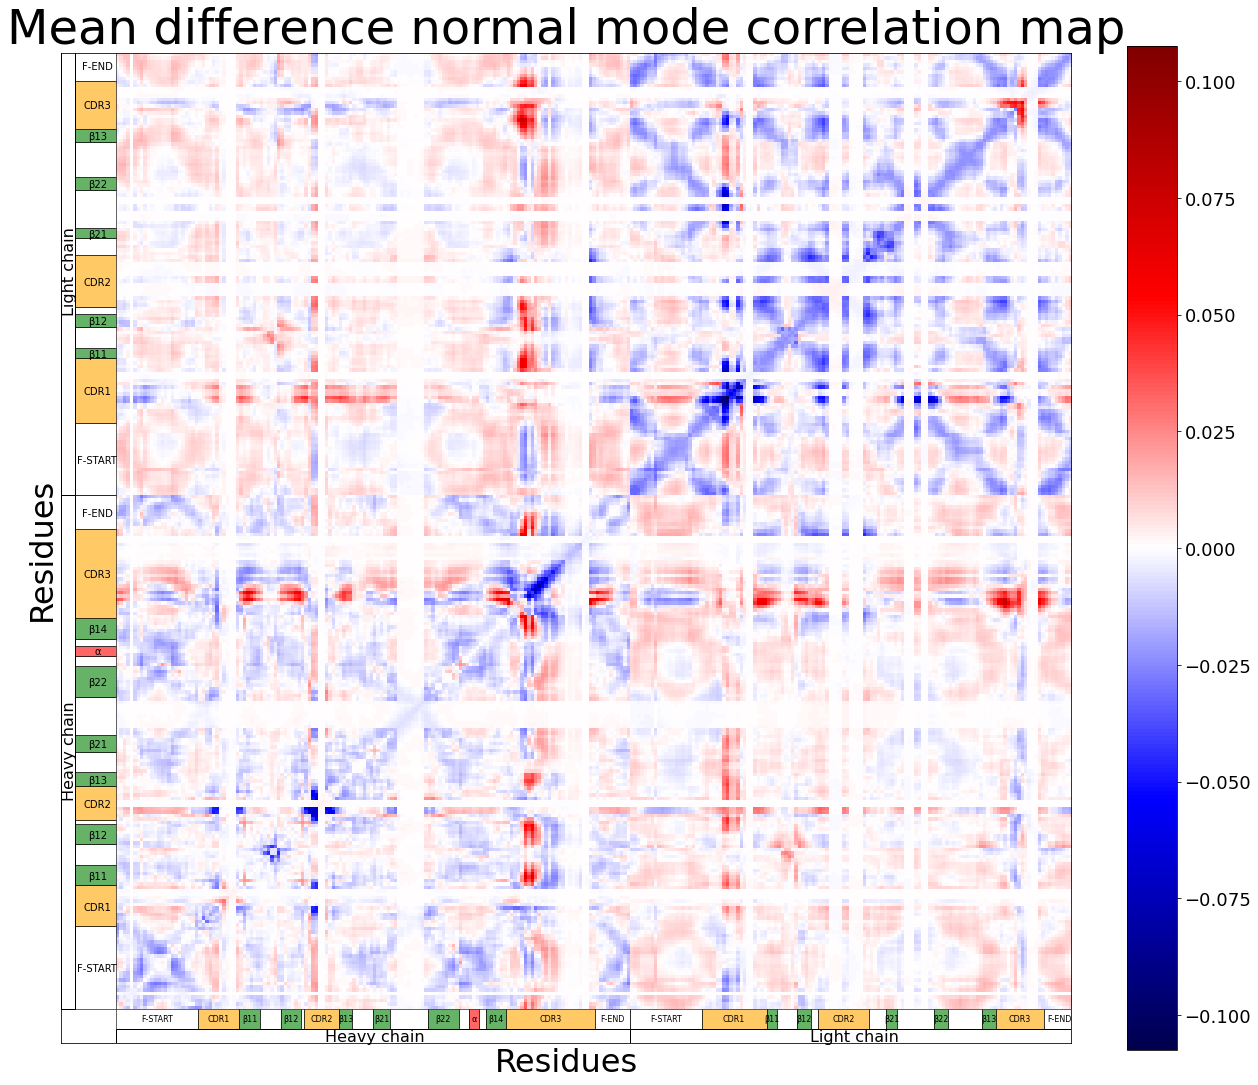

In [6]:
plot_map_with_regions(preprocessed_data, mean_diff_image, 'Mean difference normal mode correlation map')

# Contribution of a test sample

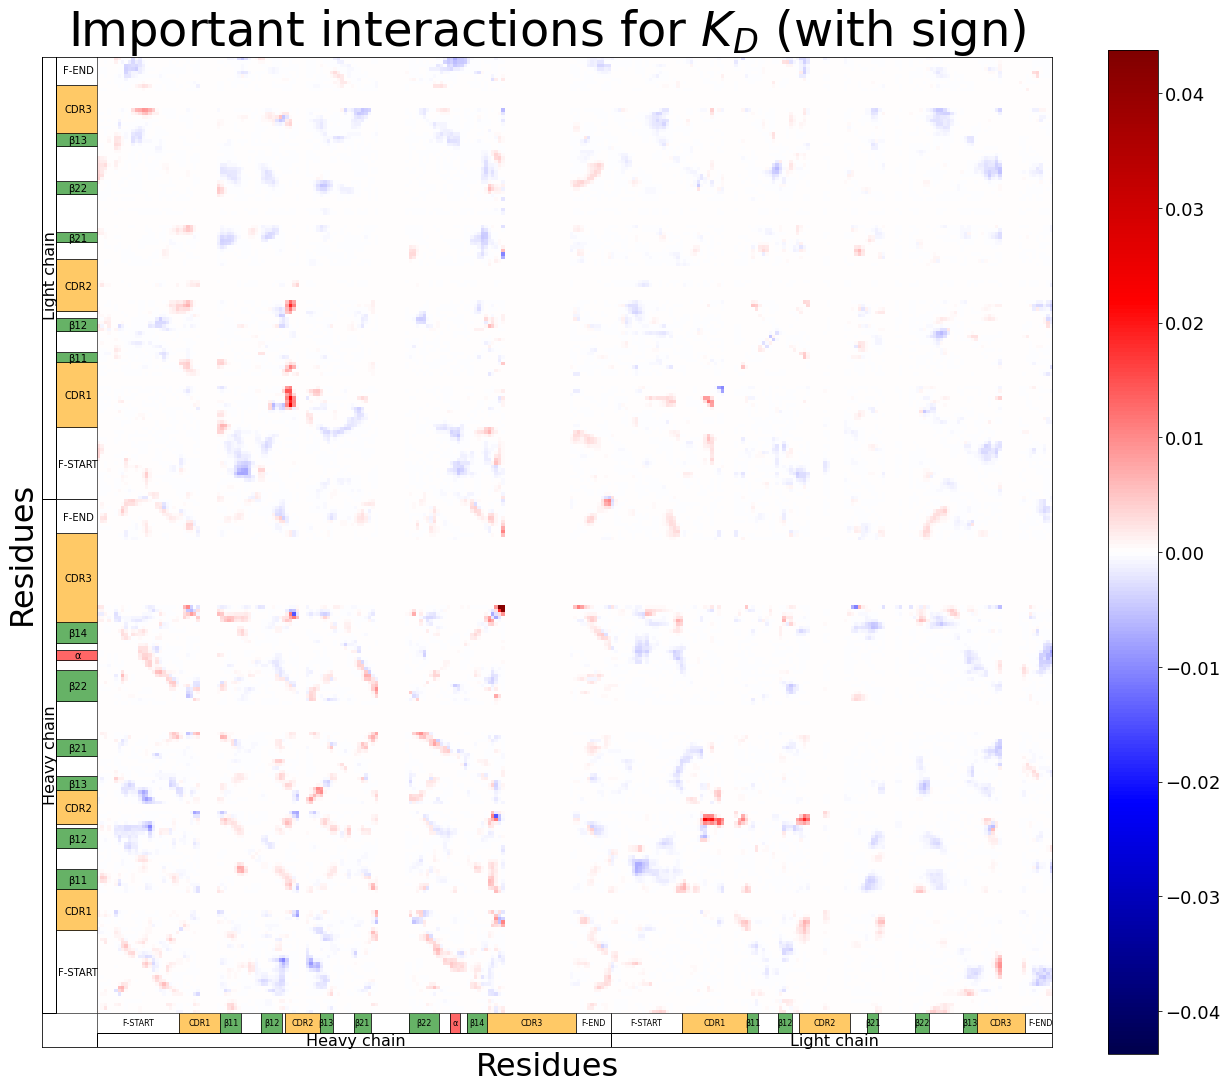

In [7]:
contribution_germline = get_test_contribution(preprocessed_data, model)
plot_map_with_regions(preprocessed_data, contribution_germline, 'Important interactions for $K_D$ (with sign)')

# Obtaining $\epsilon$

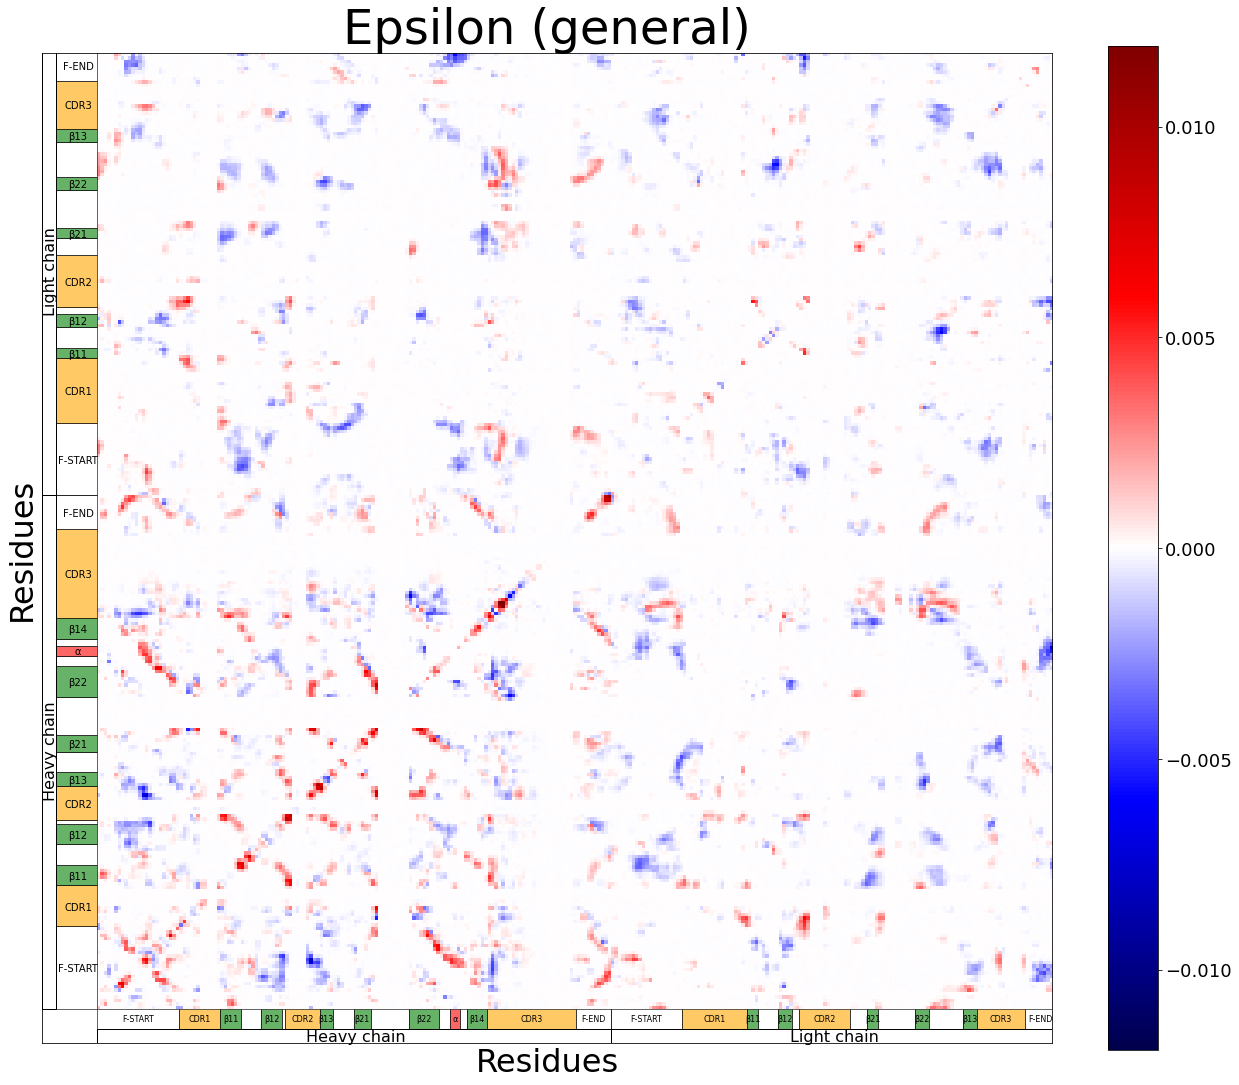

In [8]:
epsilon_gen = get_epsilon(preprocessed_data, model, mode='general')

plot_map_with_regions(preprocessed_data, epsilon_gen, 'Epsilon (general)')

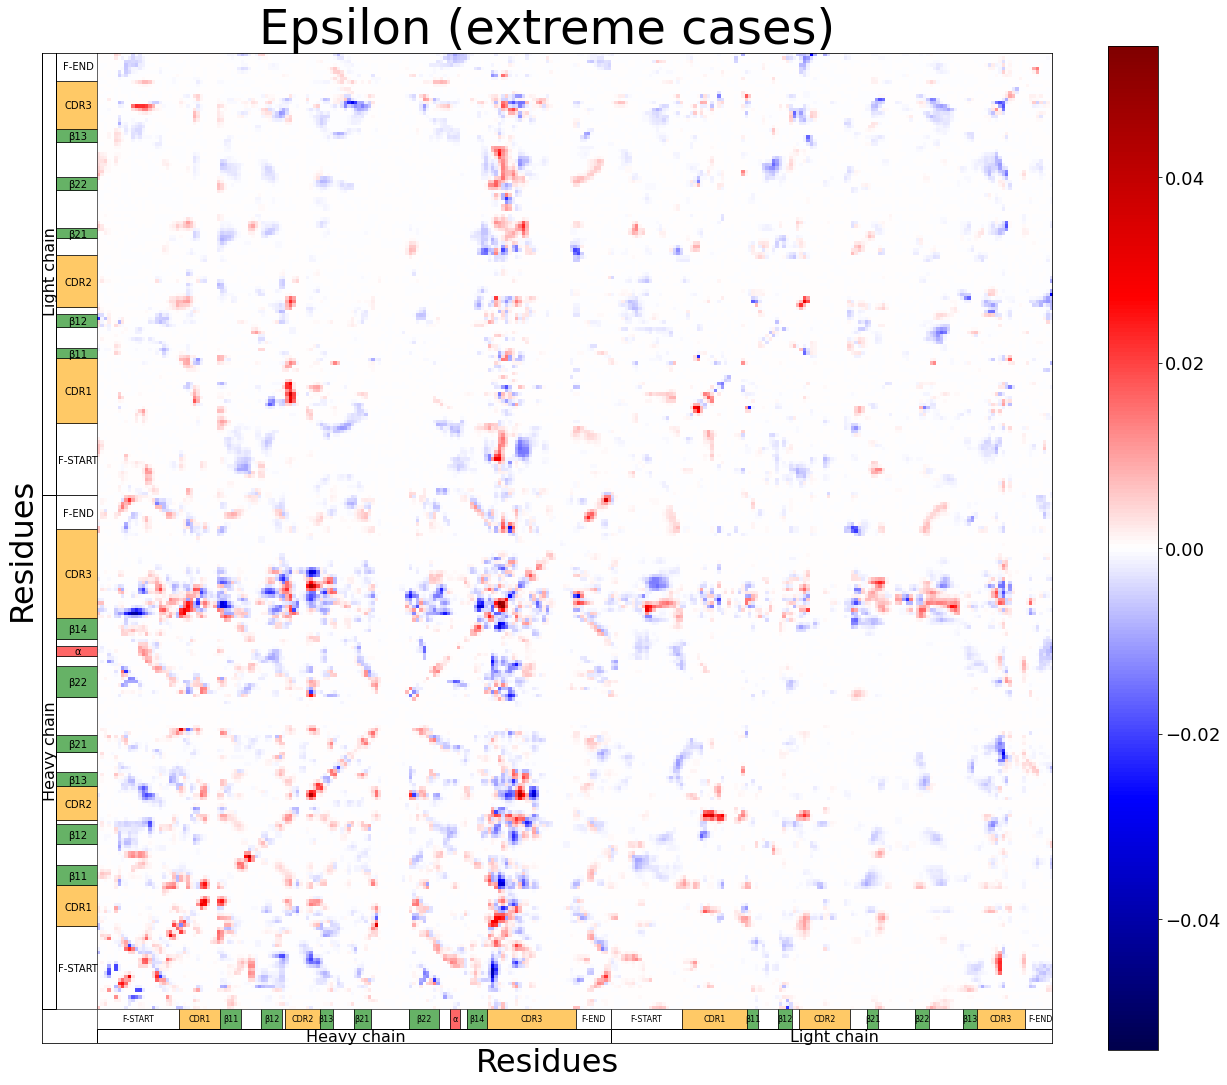

In [9]:
epsilon_ext = get_epsilon(preprocessed_data, model, mode='extreme')

plot_map_with_regions(preprocessed_data, epsilon_ext, 'Epsilon (extreme cases)')

# Change in $K_D$ when adding $\epsilon$

In [10]:
coord, maps, labels = map_residues_to_regions(preprocessed_data, epsilon_gen)

In [11]:
# Here it is possible to tune the weight of each antibody region

# Heavy chain
cdr1_factor_h = 0.1
beta11_factor_h = 0.1 
beta12_factor_h = 0.1 
cdr2_factor_h = 0.1 
beta13_factor_h = 0.1 
beta21_factor_h = 0.1 
beta22_factor_h = 0.1 
alpha_factor_h = 0.1 
beta14_factor_h = 0.1 
cdr3_factor_h = 0.1 

# Light chain
cdr1_factor_l = 0.1 
beta11_factor_l = 0.1 
beta12_factor_l = 0.1 
cdr2_factor_l = 0.1 
beta21_factor_l = 0.1 
beta22_factor_l = 0.1 
beta13_factor_l = 0.1 
cdr3_factor_l = 0.1 

# Expressing weights as vector
weights_h = [cdr1_factor_h, beta11_factor_h, 0.1, beta12_factor_h, 0.1, cdr2_factor_h, beta13_factor_h, 0.1, 
             beta21_factor_h, 0.1, beta22_factor_h, 0.1, alpha_factor_h, 0.1, beta14_factor_h, cdr3_factor_h]
weights_l = [cdr1_factor_l, beta11_factor_l, 0.1, beta12_factor_l, 0.1, cdr2_factor_l, 0.1, beta21_factor_l, 
             0.1, beta22_factor_l, 0.1, beta13_factor_l, cdr3_factor_l]
weights = np.array(weights_h + weights_l)

compute_change_in_kd(preprocessed_data, model, weights, coord, maps)

Without adding epsilon, Kd = 2.5120883e-07
After adding epsilon, Kd = 2.4719446e-07
Thus, Kd is smaller by 1.5980201 %


In [12]:
importance_matrix_signed = np.zeros((len(coord), len(coord)))
for j,_map in enumerate(maps):
    for i in range(len(coord)):
        importance_matrix_signed[i,j] = _map[coord[i],:].sum()

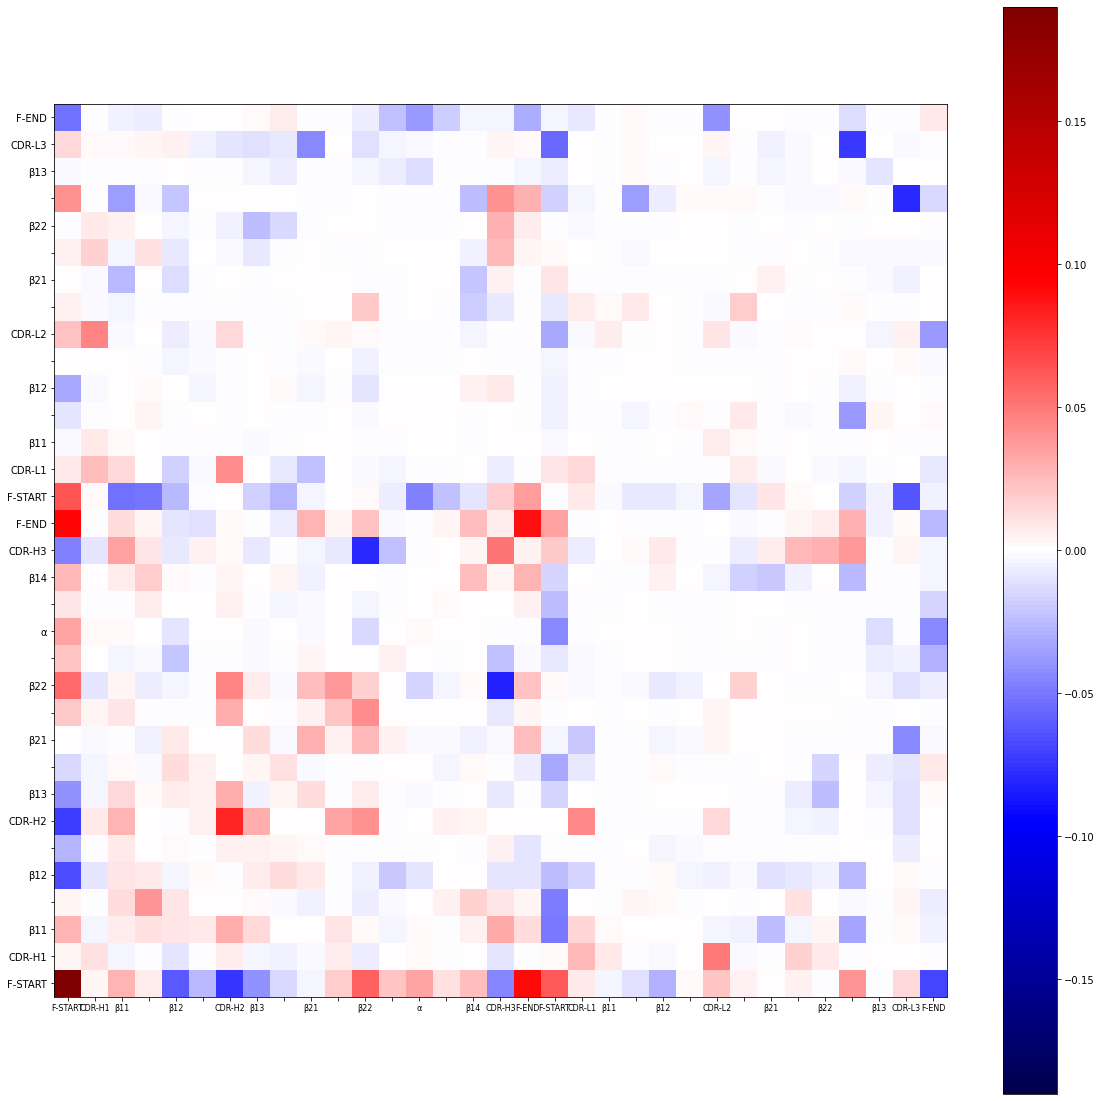

In [13]:
fig = plt.figure(figsize=(20, 20))
plt.imshow(importance_matrix_signed, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.xticks(np.arange(len(coord)), labels, size=8)
plt.yticks(np.arange(len(coord)), labels)
plt.colorbar()
plt.show()

In [14]:
importance_matrix = np.abs(importance_matrix_signed)

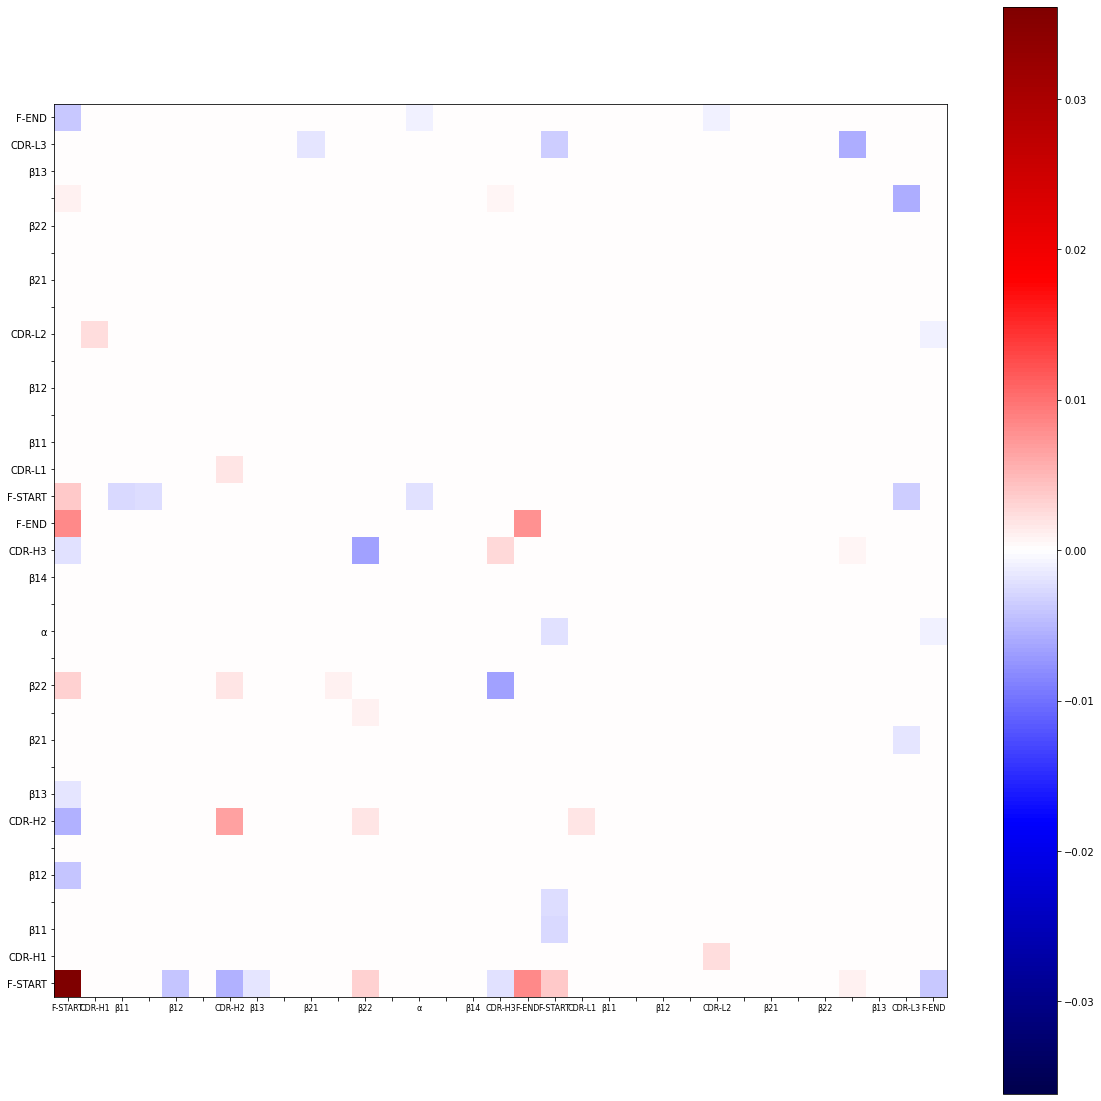

In [15]:
im = np.multiply(np.where(importance_matrix<0.04, 0, importance_matrix), importance_matrix_signed)

fig = plt.figure(figsize=(20, 20))
plt.imshow((im + np.transpose(im))/2, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.xticks(np.arange(len(coord)), labels, size=8)
plt.yticks(np.arange(len(coord)), labels)
plt.colorbar()
plt.show()

## One region at a time

In [16]:
for i in range(len(coord)):
    weights_at_a_time = np.zeros((len(coord)))
    weights_at_a_time[i] = 0.1
    print('---------------------------------------------')
    print(labels[i])
    compute_change_in_kd(preprocessed_data, model, weights_at_a_time, coord, maps)

---------------------------------------------
F-START
Without adding epsilon, Kd = 2.5120883e-07
After adding epsilon, Kd = 2.5051145e-07
Thus, Kd is smaller by 0.27761105 %
---------------------------------------------
CDR-H1
Without adding epsilon, Kd = 2.5120883e-07
After adding epsilon, Kd = 2.5092655e-07
Thus, Kd is smaller by 0.112370424 %
---------------------------------------------
β11
Without adding epsilon, Kd = 2.5120883e-07
After adding epsilon, Kd = 2.5101585e-07
Thus, Kd is smaller by 0.07682191 %
---------------------------------------------

Without adding epsilon, Kd = 2.5120883e-07
After adding epsilon, Kd = 2.5109716e-07
Thus, Kd is smaller by 0.044452615 %
---------------------------------------------
β12
Without adding epsilon, Kd = 2.5120883e-07
After adding epsilon, Kd = 2.510172e-07
Thus, Kd is smaller by 0.076278836 %
---------------------------------------------

Without adding epsilon, Kd = 2.5120883e-07
After adding epsilon, Kd = 2.5115946e-07
Thus, Kd is s

# PCA

In [17]:
pca = PCA(2) # 2 principal components

In [18]:
train_x = preprocessed_data.train_x
train_y = preprocessed_data.train_y
n_filters = model.n_filters
each_img_enl = np.zeros((train_x.shape[0], input_shape**2))
size_le = int(np.sqrt(model.fc1.weight.data.numpy().shape[-1] / n_filters))
labels = preprocessed_data.labels
clusters = []

for j in range(train_x.shape[0]):
    inter_filter_item = model(torch.from_numpy(train_x[j].reshape(1, 1, input_shape, input_shape).astype(np.float32)))[1].detach().numpy()
    for i in range(n_filters):
        each_img_enl[j] += cv2.resize(np.multiply(inter_filter_item[0,i], model.fc1.weight.data.numpy().reshape(n_filters, size_le**2)[i].reshape(size_le, size_le)), dsize=(input_shape, input_shape)).reshape((input_shape**2))


In [19]:
converted_data = pca.fit_transform(each_img_enl)
for j in range(train_x.shape[0]):
    if np.sum(np.multiply(each_img_enl[j].reshape(input_shape, input_shape), pca.components_[1,:].reshape(input_shape, input_shape))) <= 0:
        clusters.append('Low')
    else:
        clusters.append('High')

In [20]:
cluster_according_to = 'heavy_species'
db = pd.read_csv('../data/sabdab_summary_all.tsv', sep='\t').loc[:,['pdb',cluster_according_to]]

clusters = []
for i in range(len(labels)):
    clusters.append(str(db[db['pdb'] == labels[i]].iloc[0][cluster_according_to]))

In [21]:
cdict = {'homo sapiens': 0,
        'mus musculus': 1,
         'Other': 2}

colours = []
for i in range(len(clusters)):
    if clusters[i] in cdict:
        colours.append(cdict[clusters[i]])
    else:
        colours.append(cdict['Other'])
        clusters[i] = 'Other'

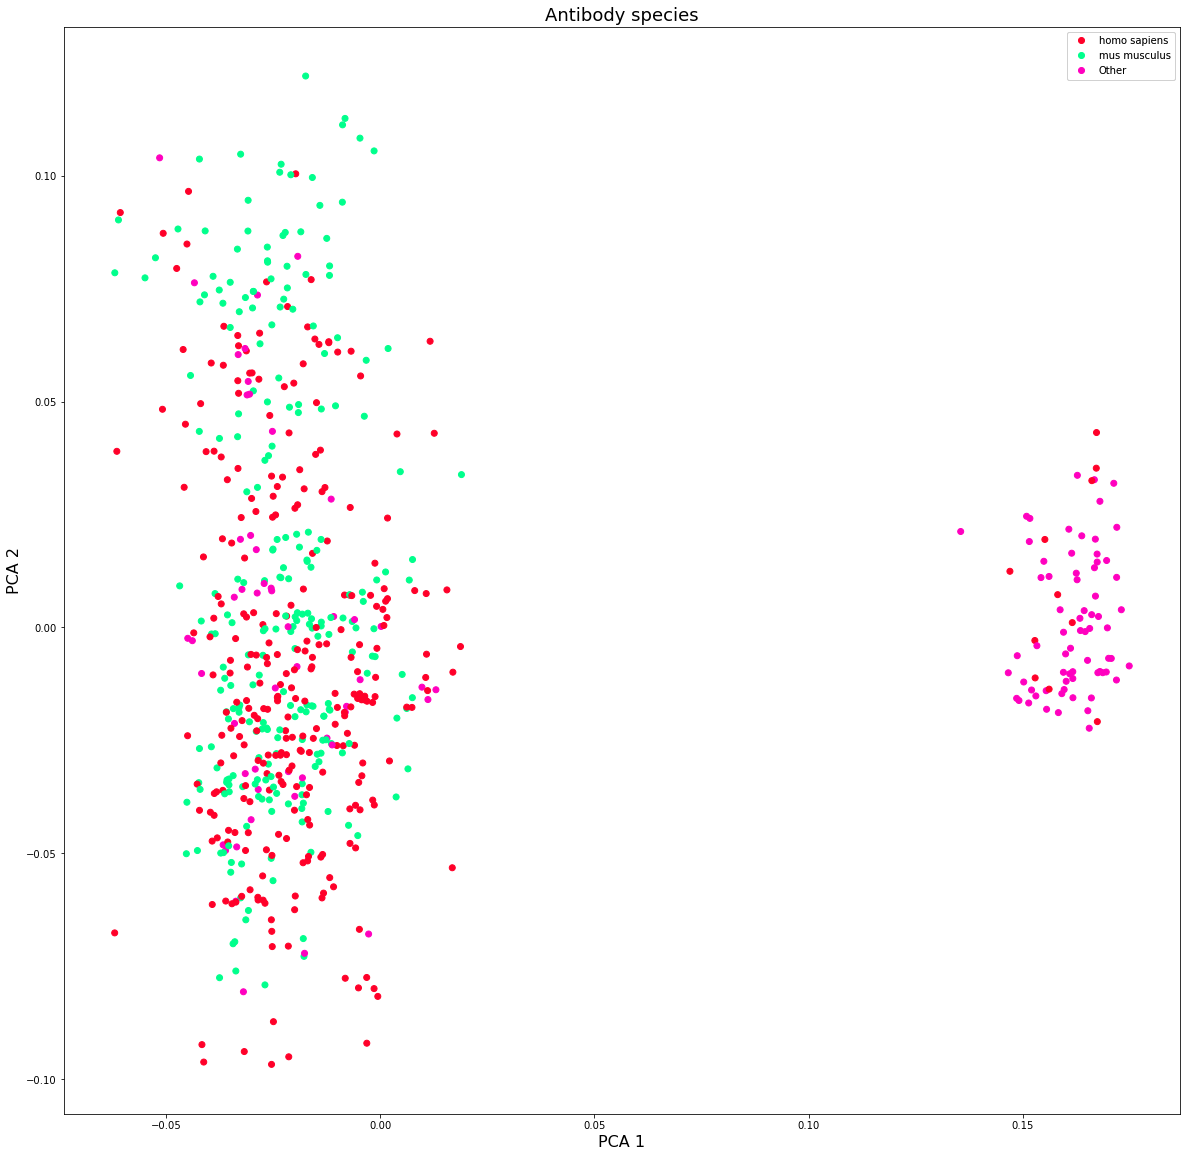

In [22]:
unique_colours = list(set(colours))
norm = plt.Normalize(np.min(colours), np.max(colours))
cmap = matplotlib.colormaps.get_cmap('gist_rainbow')
legend_patches = [mpatches.Patch(color=cmap(norm(color))) for color in unique_colours]
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.scatter(converted_data[:, 0], converted_data[:, 1], c=colours, cmap=cmap)

#for i, txt in enumerate(range(train_x.shape[0])):
#    ax.annotate(labels[i], (converted_data[i, 0], converted_data[i, 1]), size=10)

handles, _ = im.legend_elements(prop="colors") 
legend1 = ax.legend(handles, cdict.keys(), loc='upper right')
ax.add_artist(legend1)
ax.set_title('Antibody species', size=18)
ax.set_xlabel('PCA 1', size=16)
ax.set_ylabel('PCA 2', size=16)
plt.show()

plt.show()


In [23]:
pca.explained_variance_ratio_

array([0.19721306, 0.09619885])

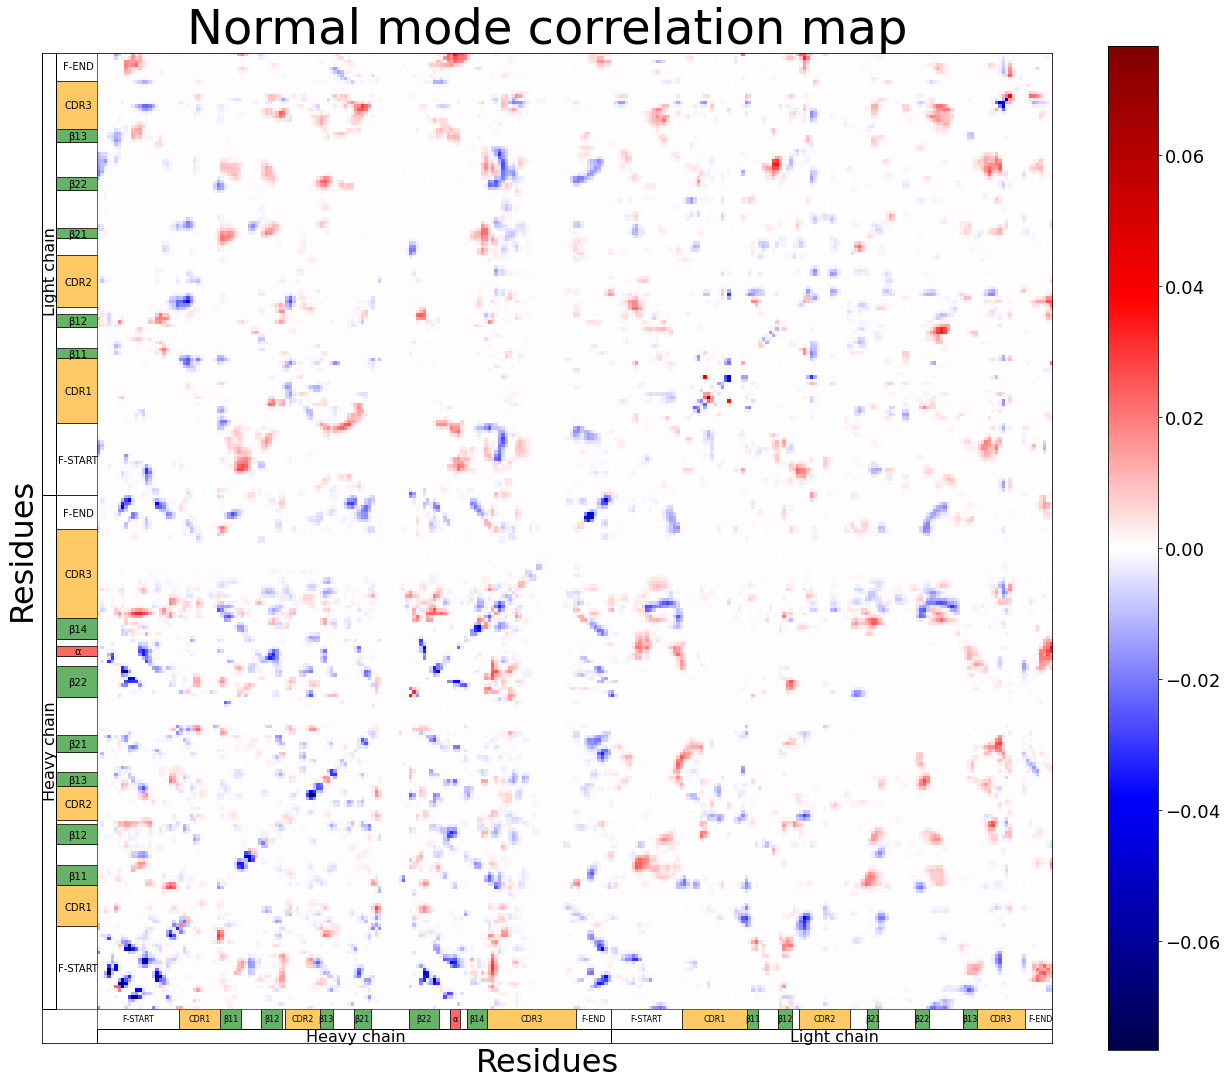

In [24]:
plot_map_with_regions(preprocessed_data, pca.components_[0,:].reshape(input_shape, input_shape))

# UMAP

In [25]:
aromaticity = np.load('biological_properties/aromaticity.npy')
hydrophobicity = np.load('biological_properties/hydrophobicity.npy')
charge = np.load('biological_properties/charge.npy')
polarity = np.load('biological_properties/polarity.npy')

# Uncomment the following line to recompute the scores (computationally expensive)
#aromaticity, hydrophobicity, charge, polarity = get_types_of_residues(labels)

cdrh1_l, cdrh2_l, cdrh3_l, cdrl1_l, cdrl2_l, cdrl3_l = get_cdr_lengths(labels)

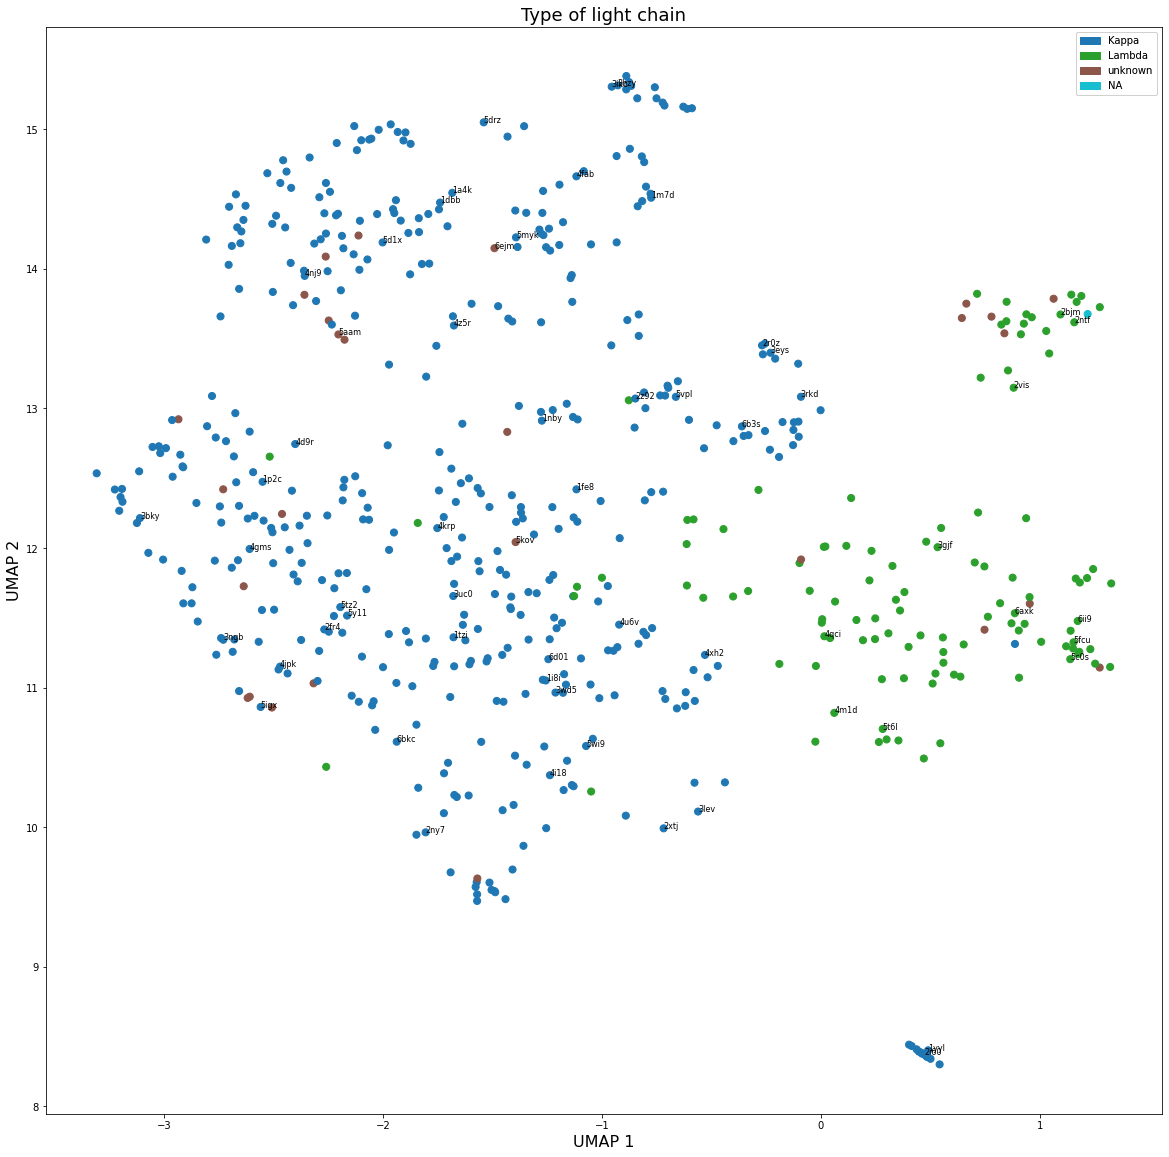

In [26]:
compute_umap(preprocessed_data, model, scheme='light_ctype', regions='paired_hl', categorical=True, include_ellipses=False, exclude_nanobodies=True)

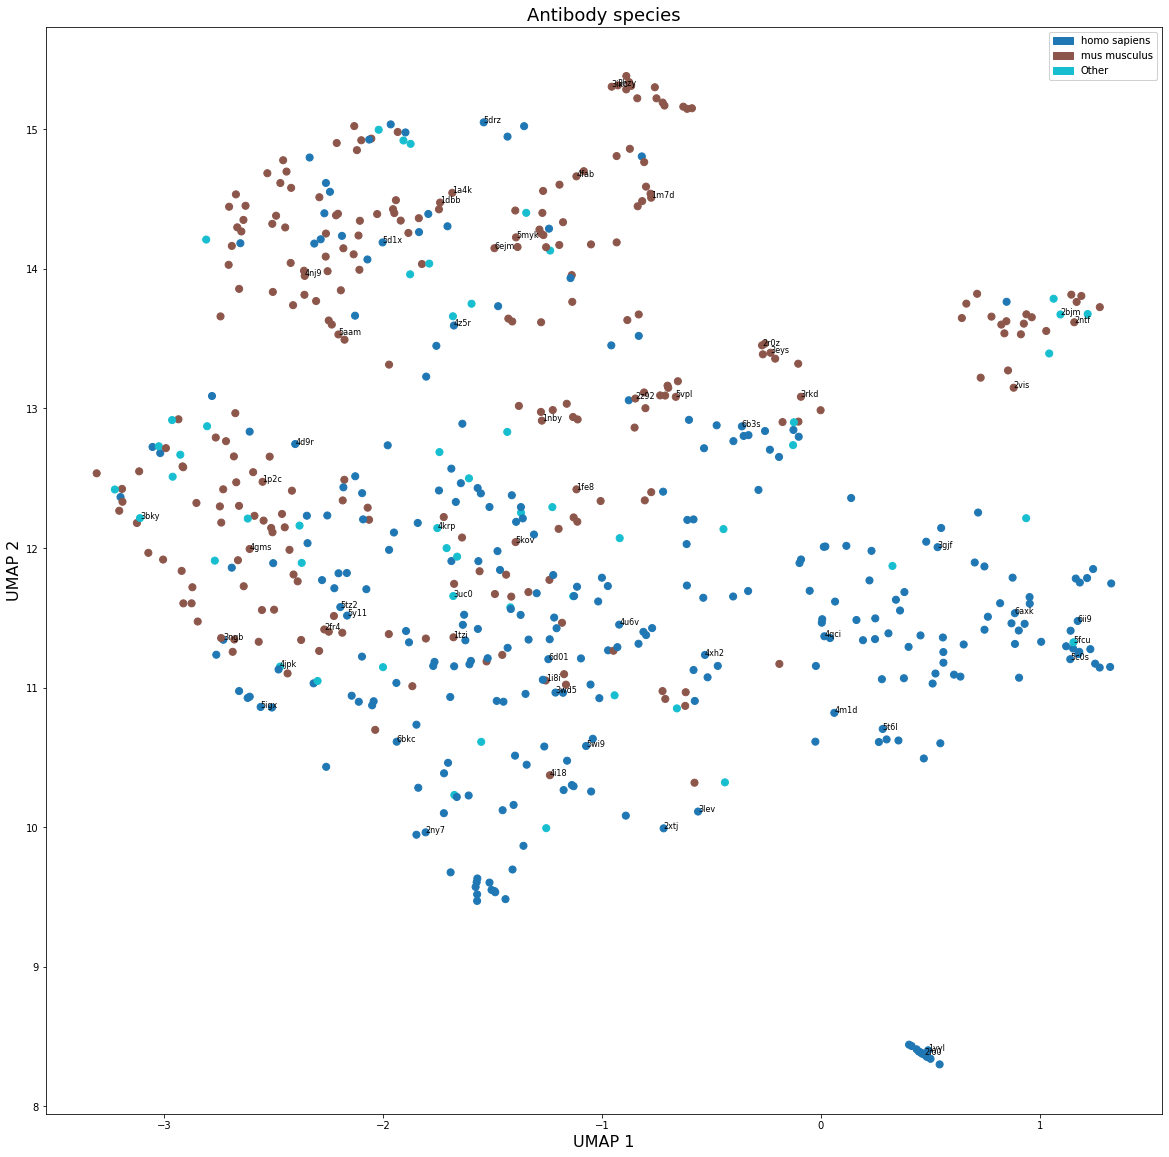

In [27]:
compute_umap(preprocessed_data, model, scheme='heavy_species', regions='paired_hl', categorical=True, include_ellipses=False, exclude_nanobodies=True)

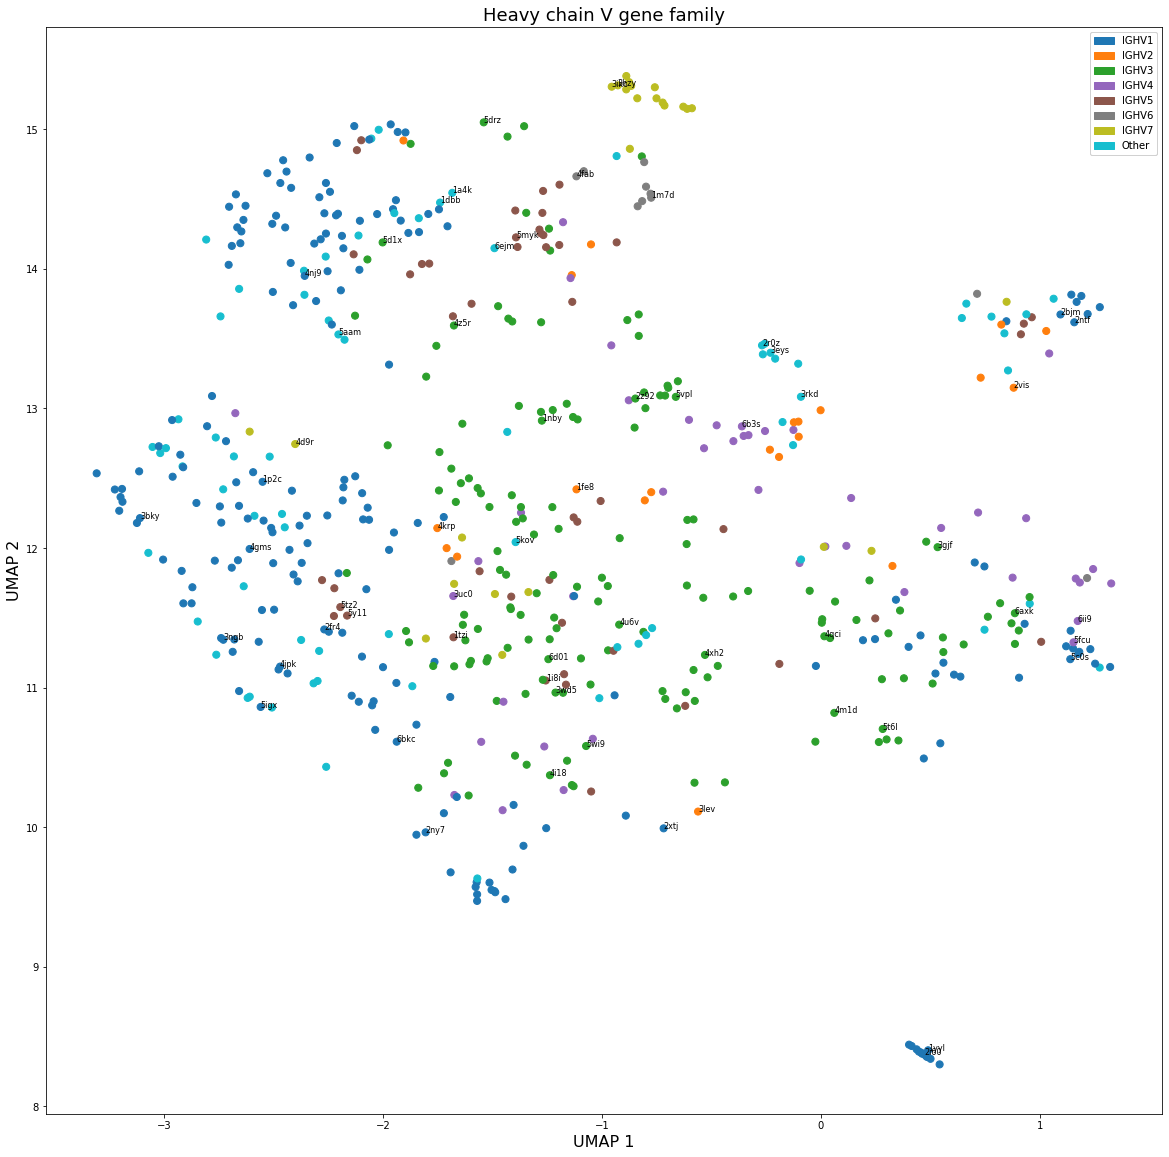

In [28]:
compute_umap(preprocessed_data, model, scheme='heavy_subclass', regions='paired_hl', categorical=True, include_ellipses=False, exclude_nanobodies=True)

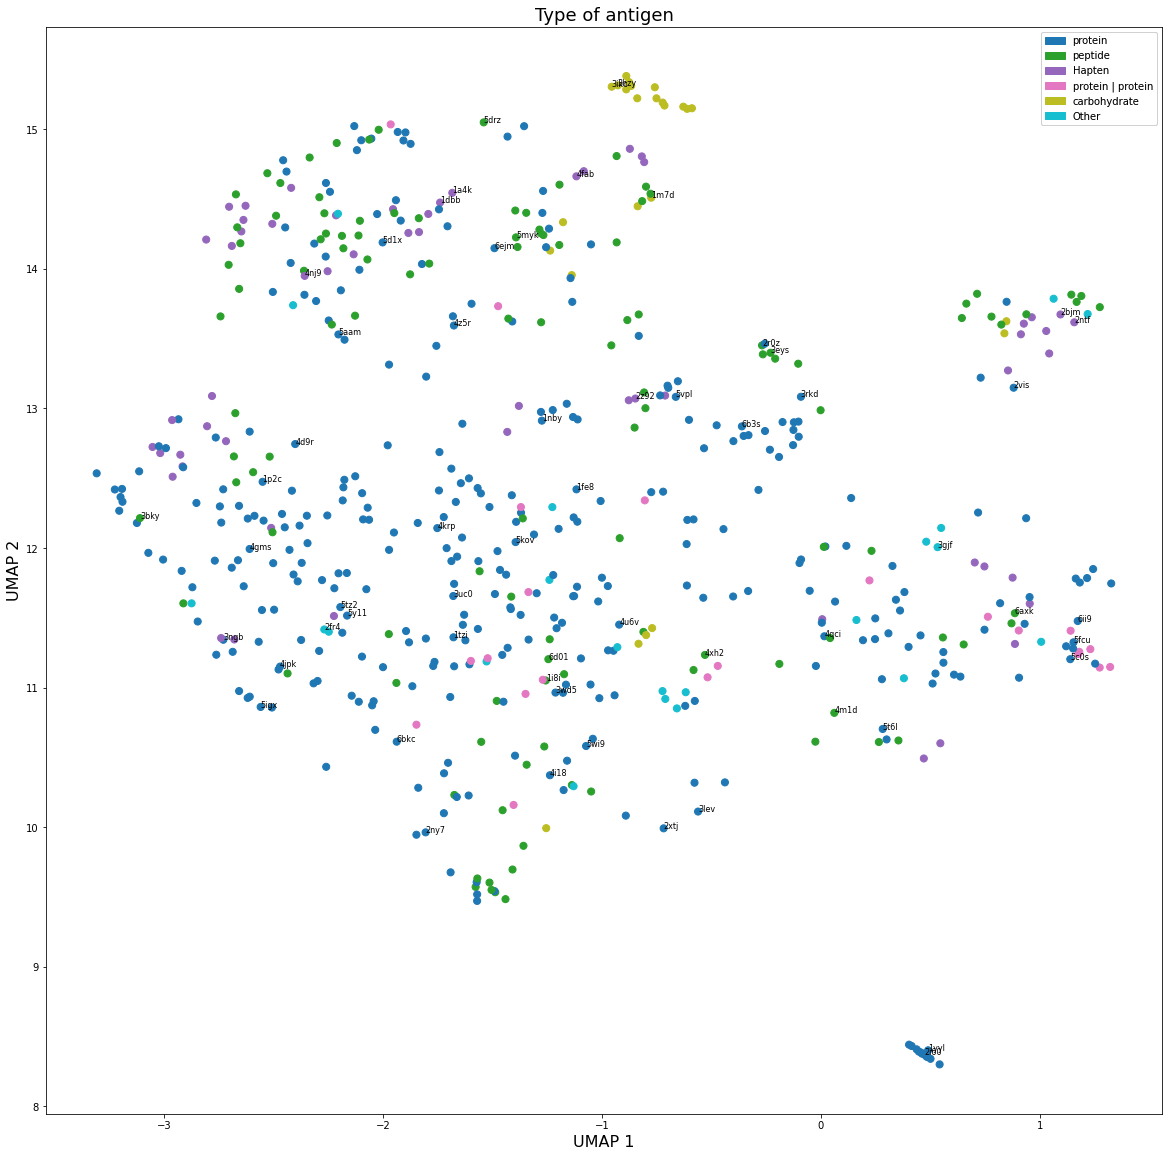

In [29]:
compute_umap(preprocessed_data, model, scheme='antigen_type', regions='paired_hl', categorical=True, include_ellipses=False, exclude_nanobodies=True)

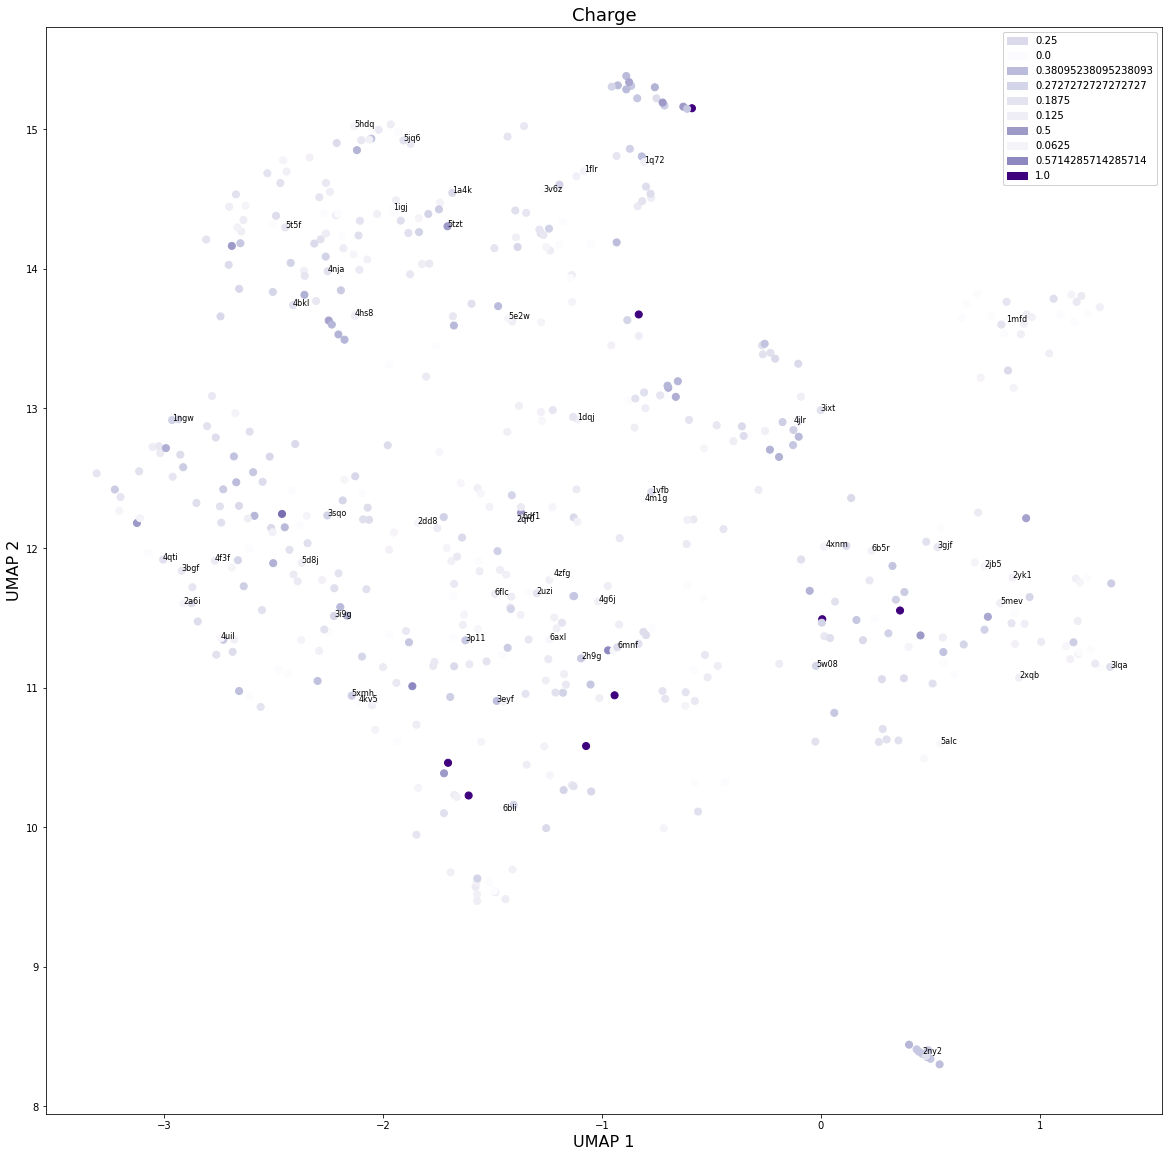

In [30]:
compute_umap(preprocessed_data, model, scheme='Charge', regions='paired_hl', categorical=False, numerical_values=charge, exclude_nanobodies=True)

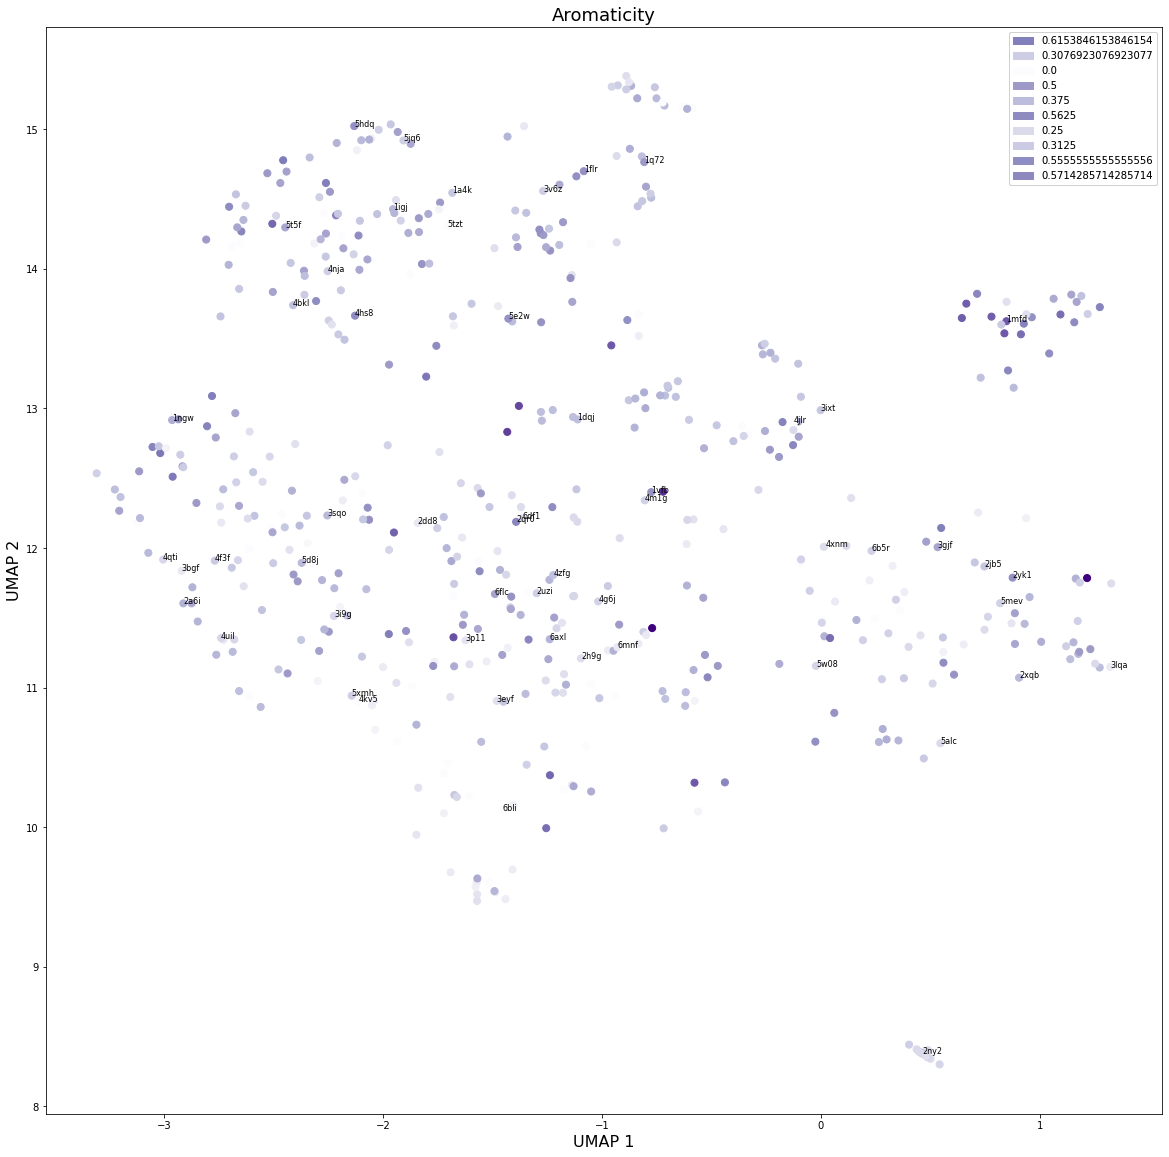

In [31]:
compute_umap(preprocessed_data, model, scheme='Aromaticity', regions='paired_hl', categorical=False, numerical_values=aromaticity,  exclude_nanobodies=True)

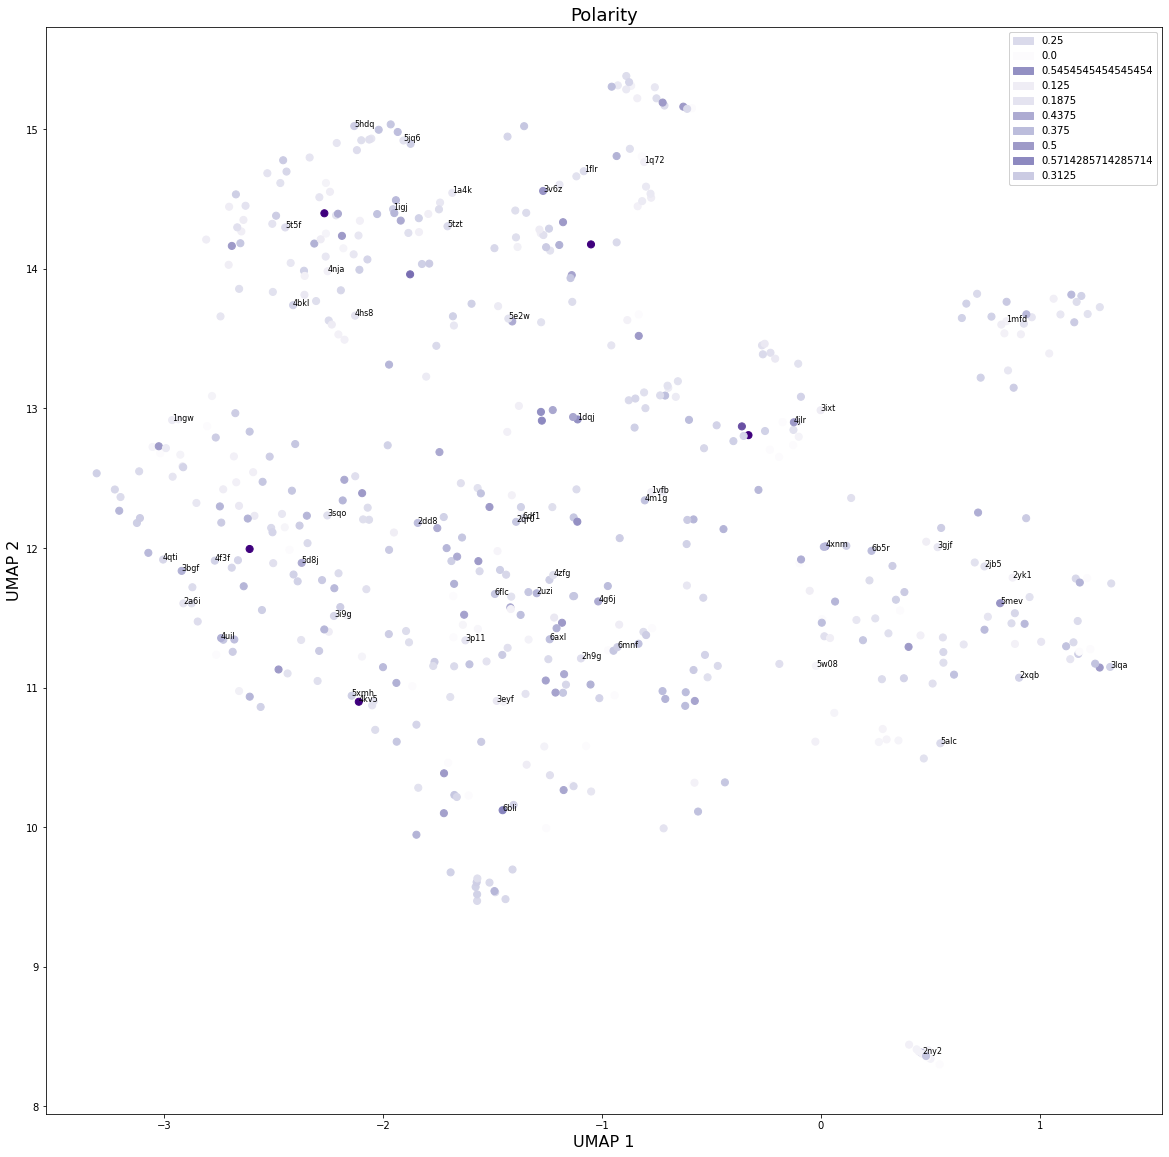

In [32]:
compute_umap(preprocessed_data, model, scheme='Polarity', regions='paired_hl', categorical=False, numerical_values=polarity, exclude_nanobodies=True)

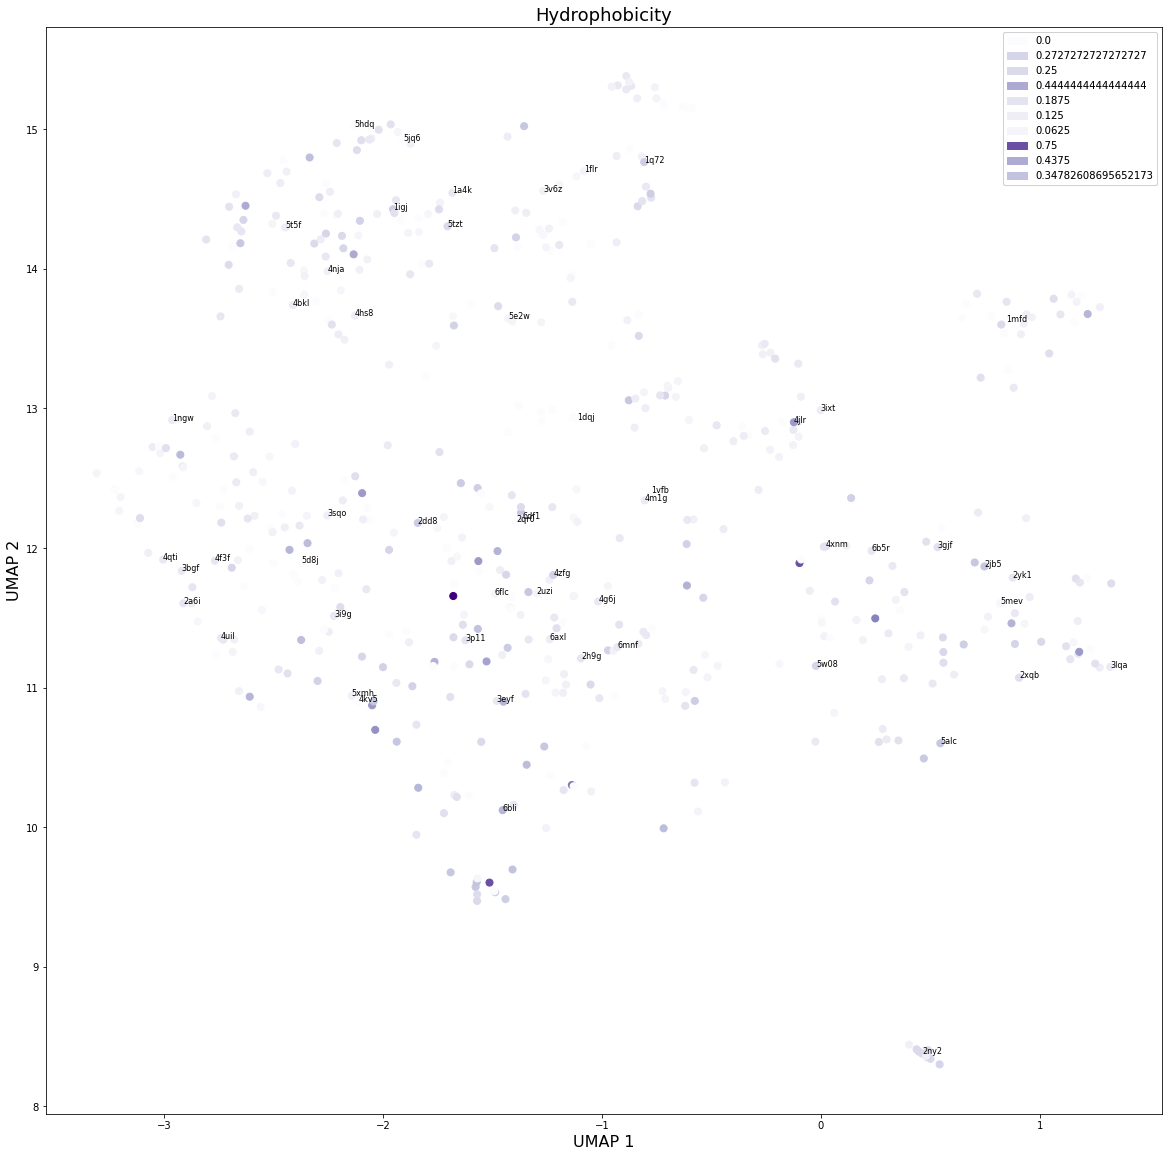

In [33]:
compute_umap(preprocessed_data, model, scheme='Hydrophobicity', regions='paired_hl', categorical=False, numerical_values=hydrophobicity, exclude_nanobodies=True)

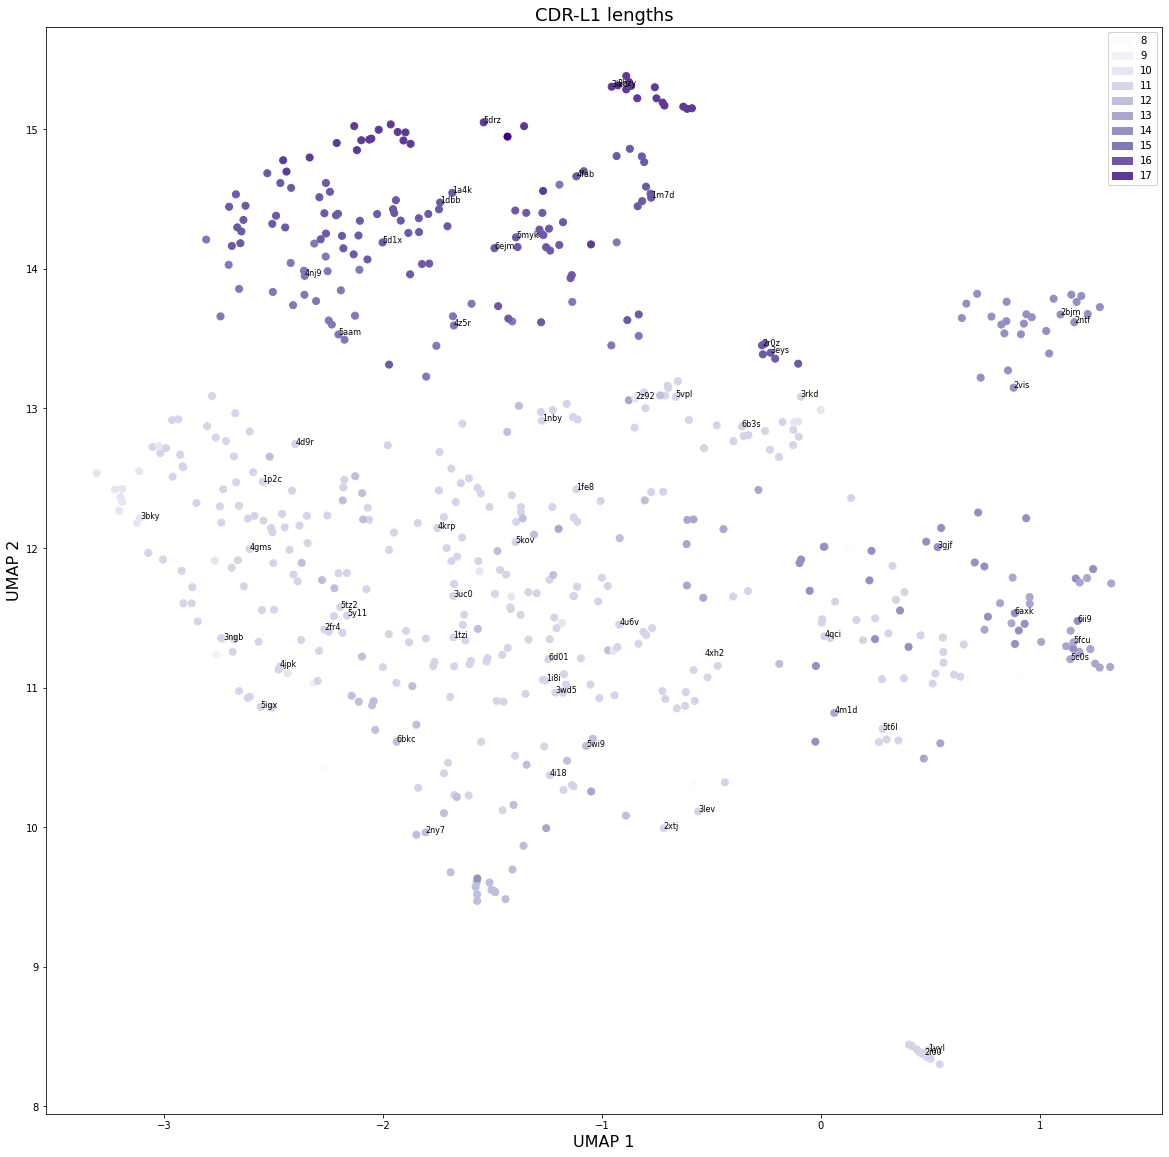

In [34]:
compute_umap(preprocessed_data, model, scheme='CDR-L1 lengths', regions='paired_hl', categorical=False, numerical_values=cdrl1_l, exclude_nanobodies=True)

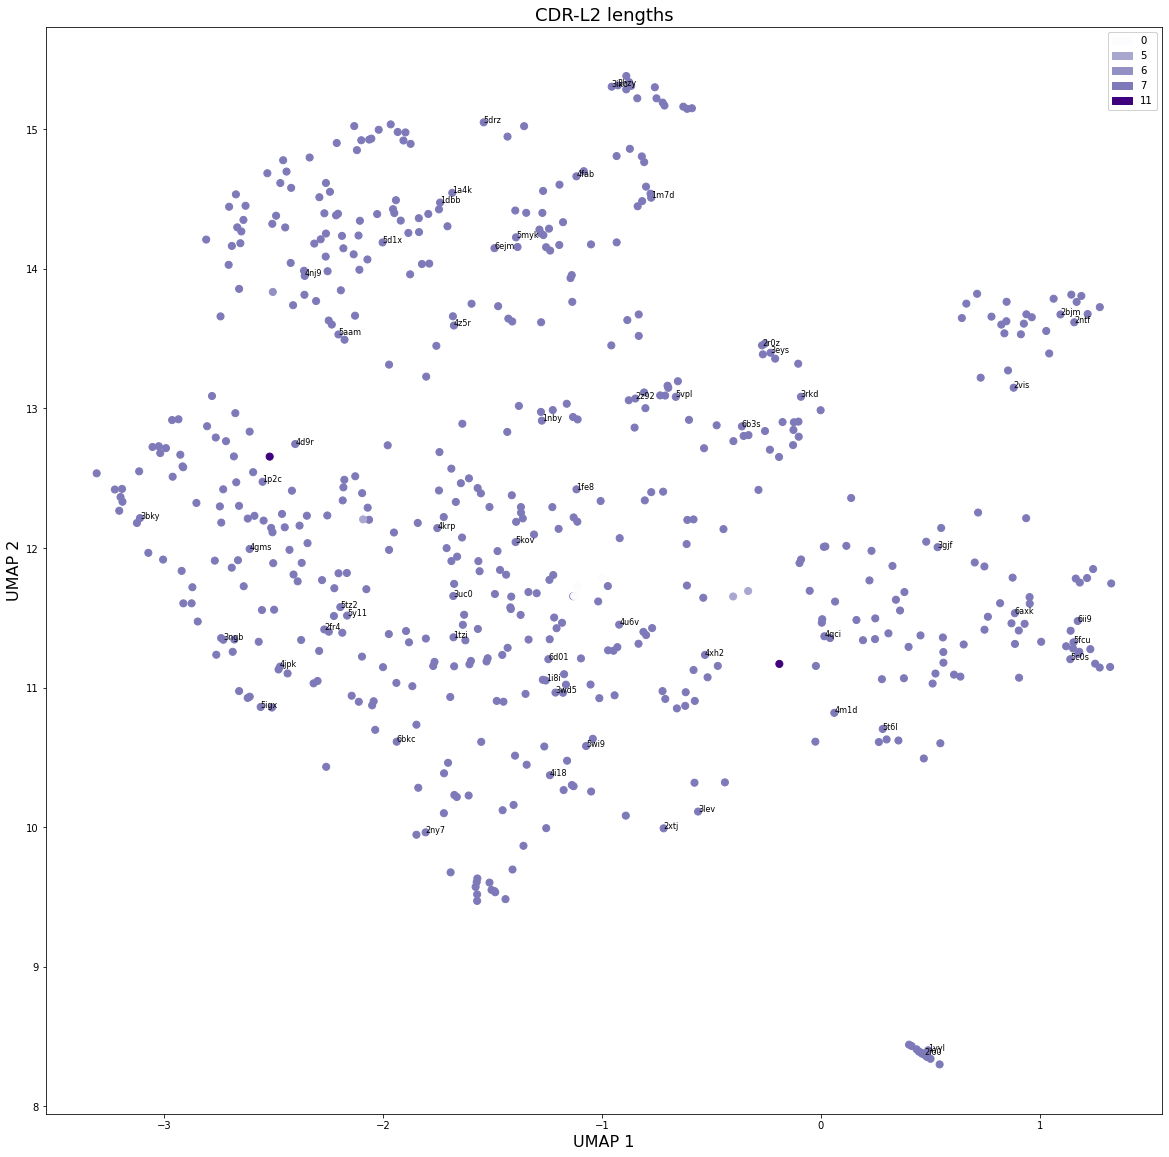

In [35]:
compute_umap(preprocessed_data, model, scheme='CDR-L2 lengths', regions='paired_hl', categorical=False, numerical_values=cdrl2_l, exclude_nanobodies=True)

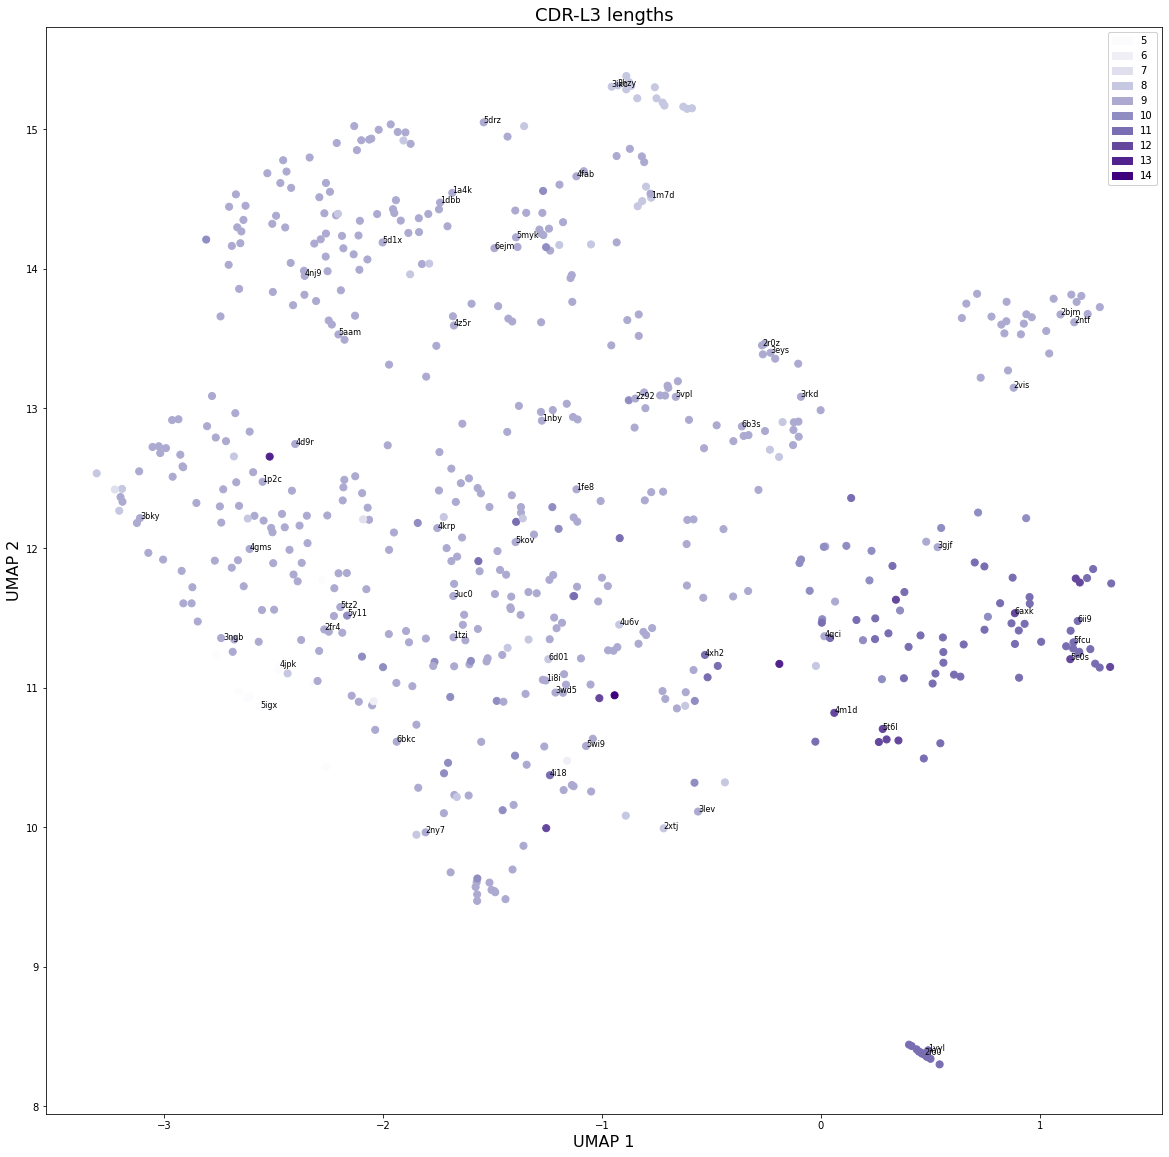

In [36]:
compute_umap(preprocessed_data, model, scheme='CDR-L3 lengths', regions='paired_hl', categorical=False, numerical_values=cdrl3_l, exclude_nanobodies=True)

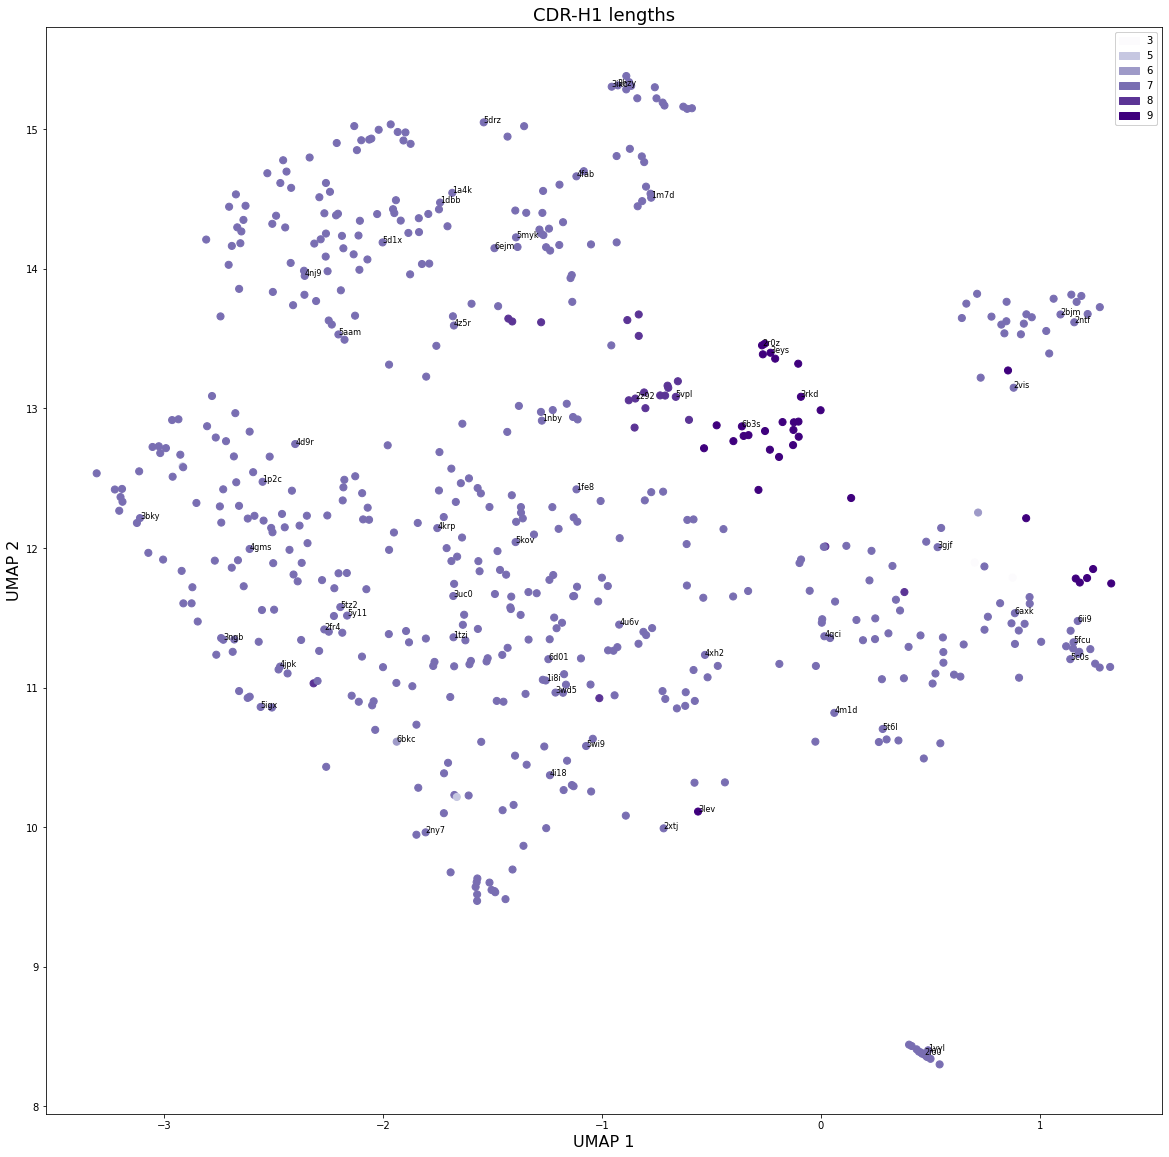

In [37]:
compute_umap(preprocessed_data, model, scheme='CDR-H1 lengths', regions='paired_hl', categorical=False, numerical_values=cdrh1_l, exclude_nanobodies=True)

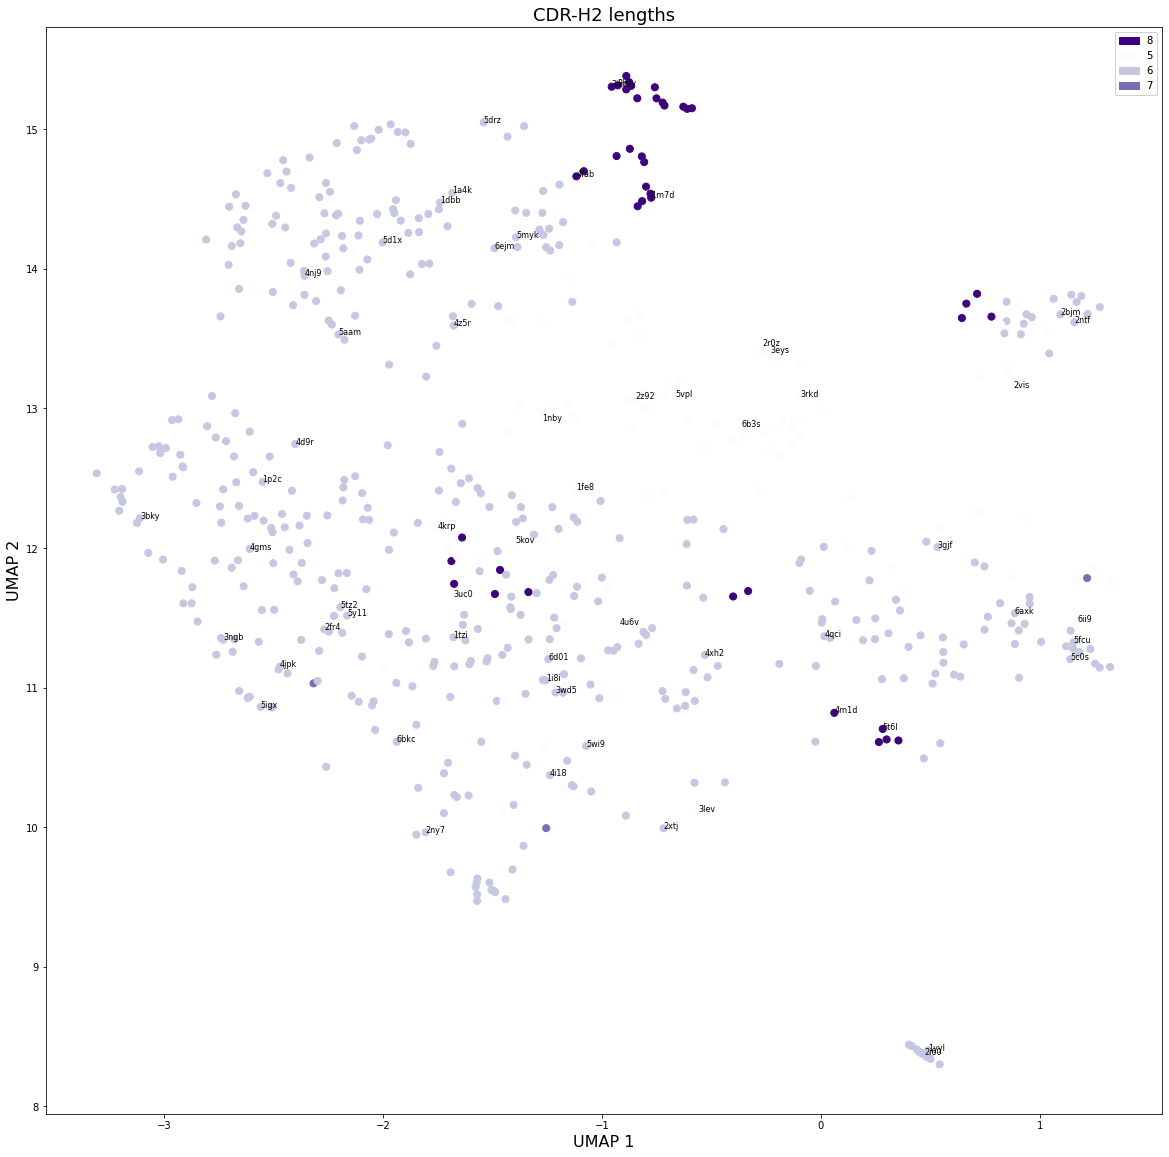

In [38]:
compute_umap(preprocessed_data, model, scheme='CDR-H2 lengths', regions='paired_hl', categorical=False, numerical_values=cdrh2_l, exclude_nanobodies=True)

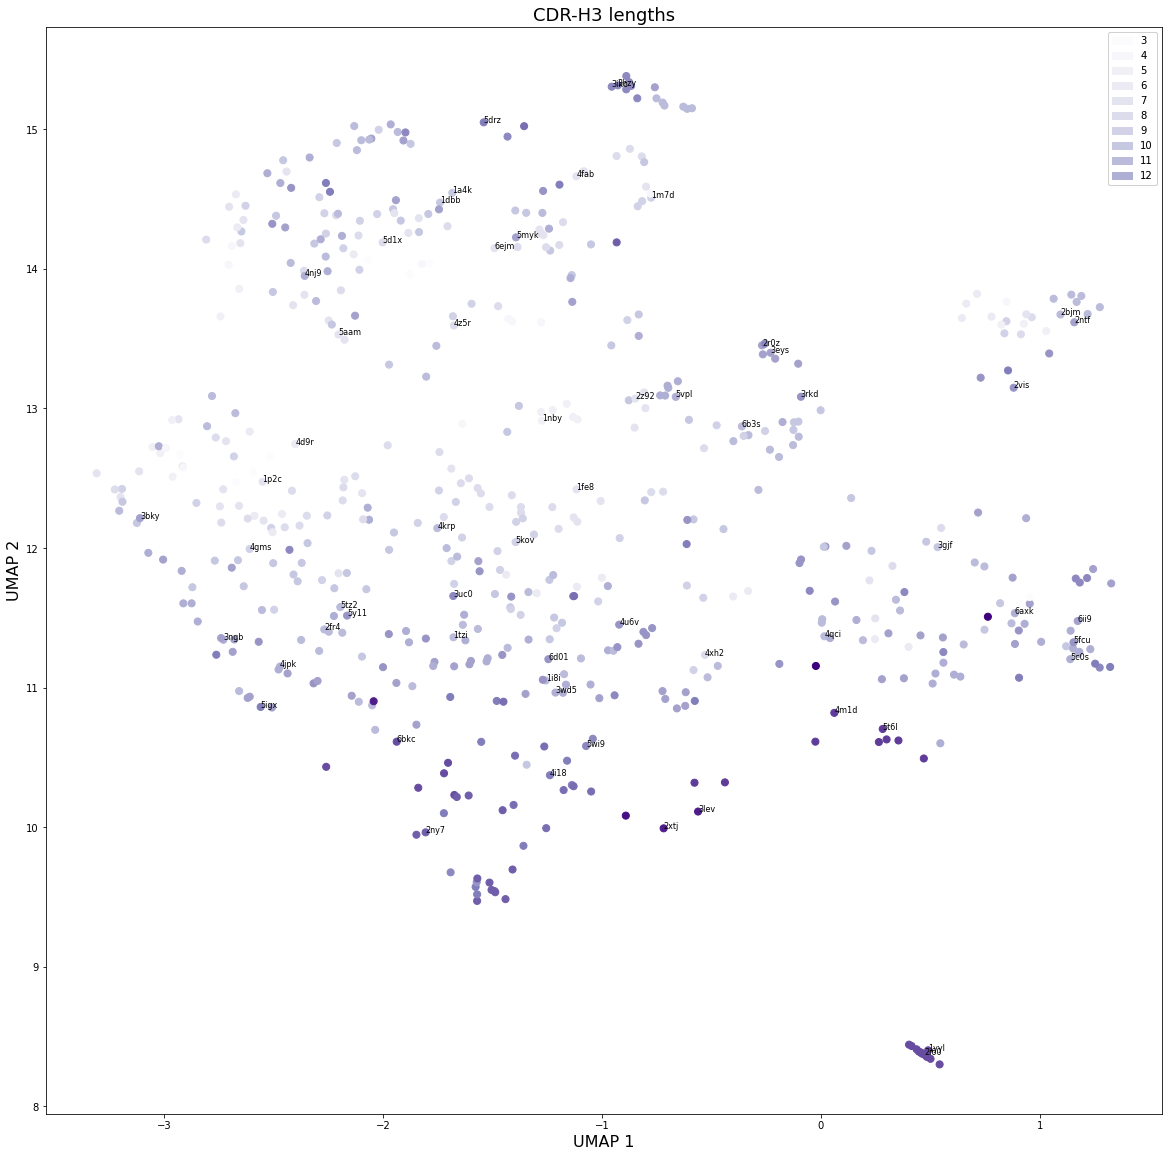

In [39]:
compute_umap(preprocessed_data, model, scheme='CDR-H3 lengths', regions='paired_hl', categorical=False, numerical_values=cdrh3_l, exclude_nanobodies=True)

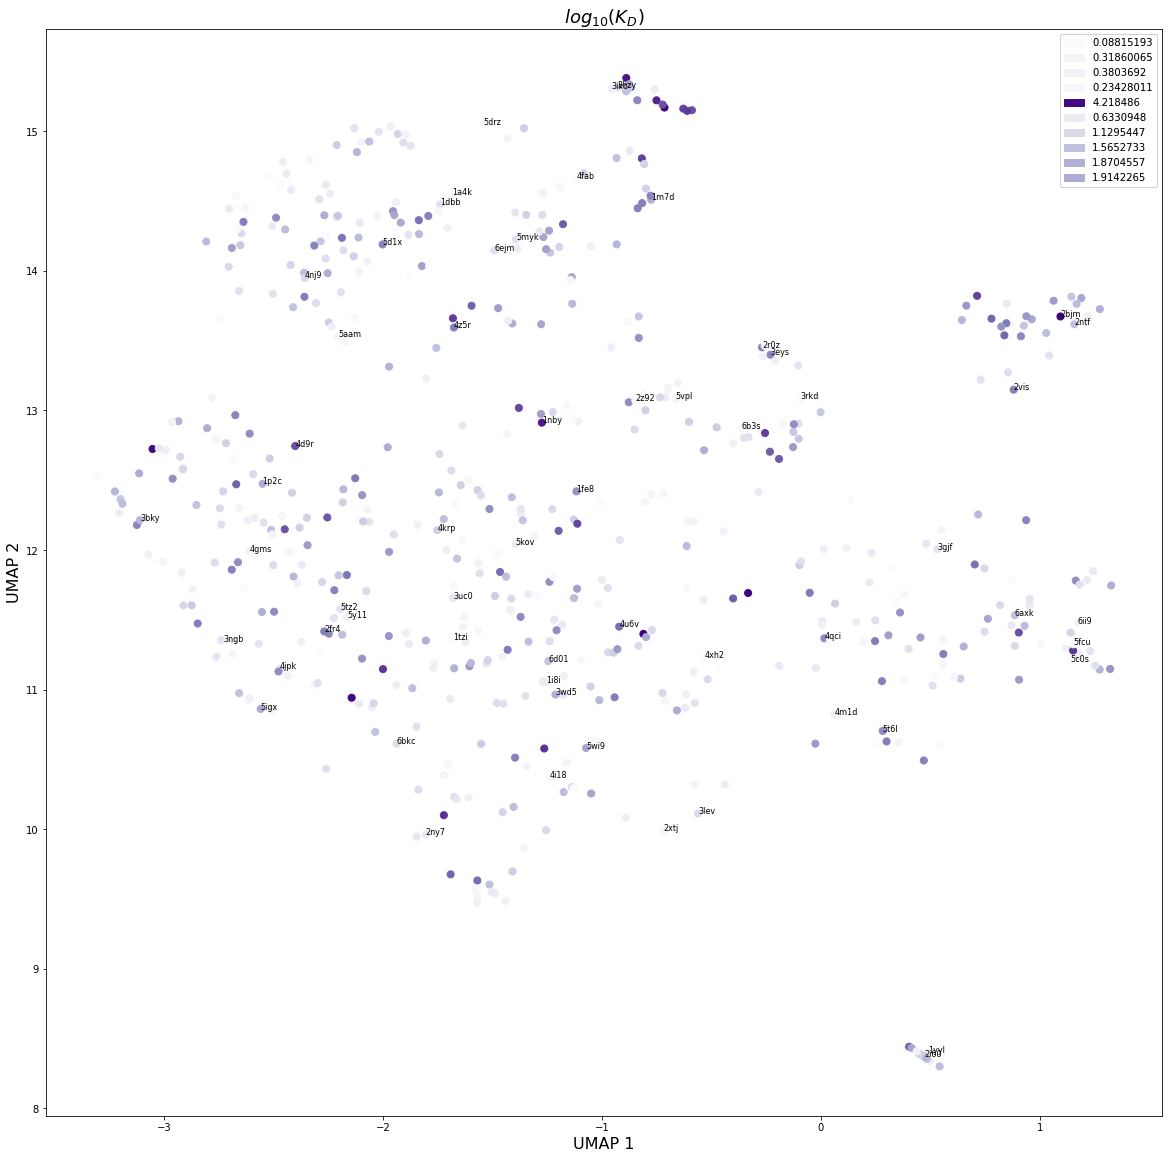

In [40]:
compute_umap(preprocessed_data, model, scheme='$log_{10}(K_D)$', regions='paired_hl', categorical=False, numerical_values=np.abs(train_y-np.mean(train_y)), exclude_nanobodies=True)

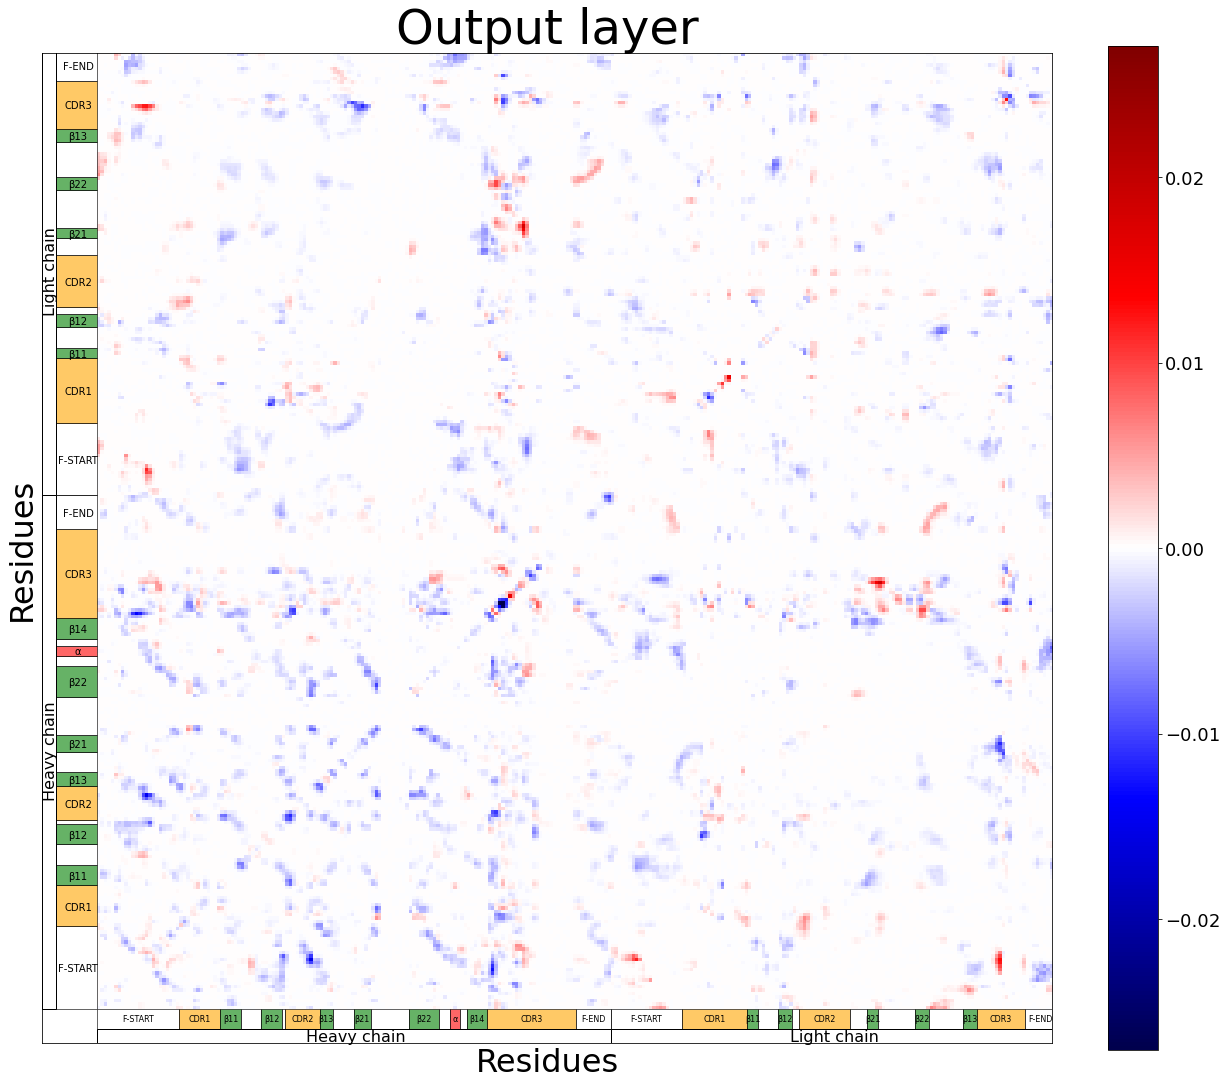

In [41]:
plot_map_with_regions(preprocessed_data, each_img_enl[labels.index('5drz')].reshape(input_shape, input_shape), 'Output layer')

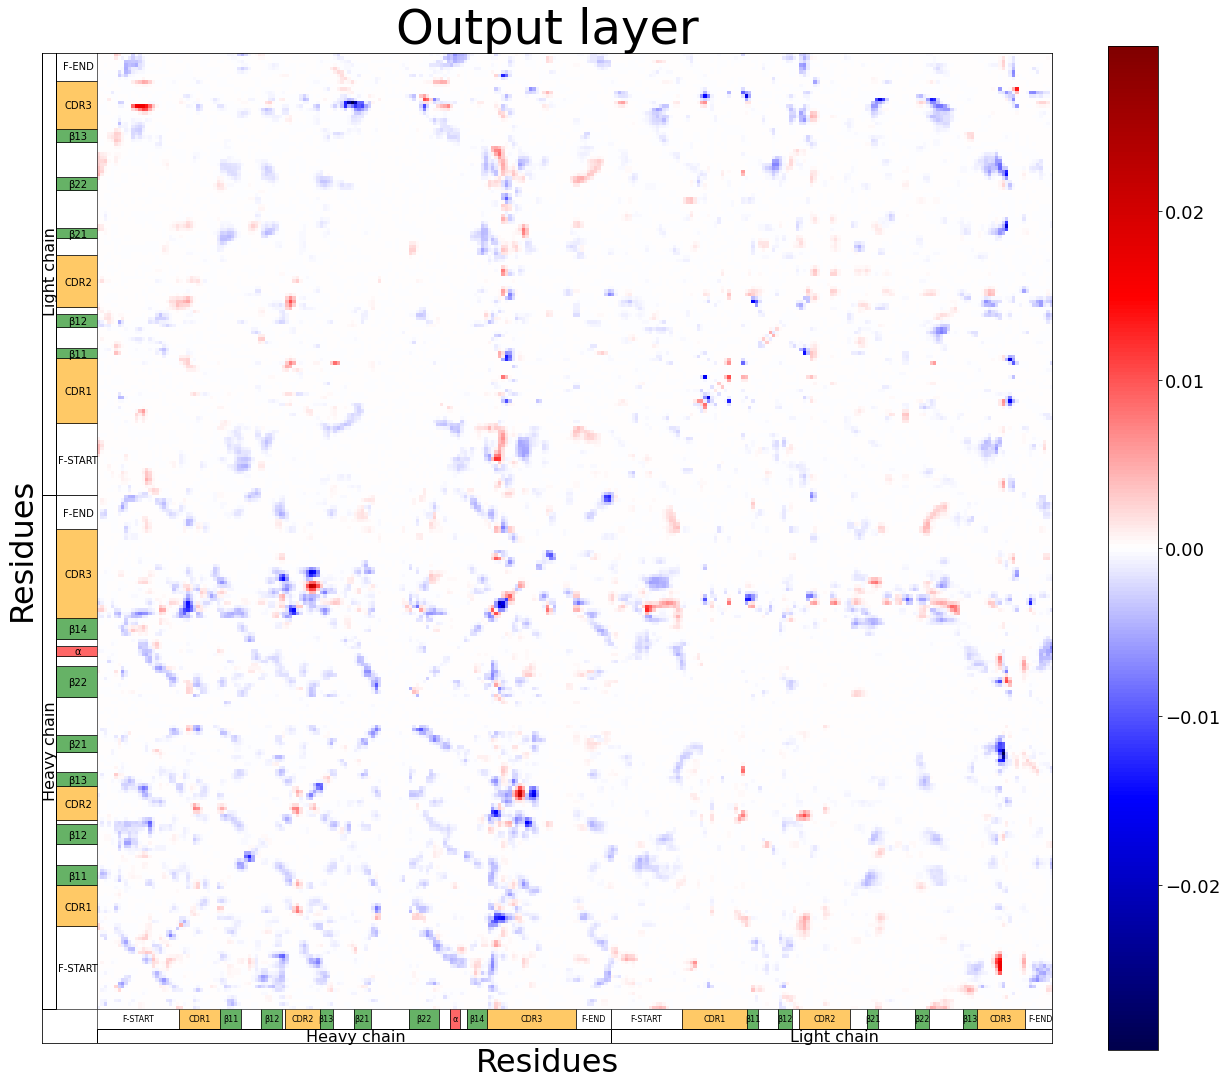

In [42]:
plot_map_with_regions(preprocessed_data, each_img_enl[labels.index('5t6l')].reshape(input_shape, input_shape), 'Output layer')